"We certify that the code and data in this assignment were generated
independently, using only the tools and resources defined in the course
and that I/we did not receive any external help, coaching or contributions
during the production of this work."


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class LudoEnv():
    
    def __init__(self, BLOCK_LEN=13, NUM_PLAYERS = 2, NUM_PIECES = 4):
        self.BLOCK_LEN = BLOCK_LEN     # 13
        self.NUM_PLAYERS = NUM_PLAYERS    # 4
        self.MAX_LEN = self.BLOCK_LEN * self.NUM_PLAYERS
        
        self.NUM_PIECES = NUM_PIECES
        self.MAX_MOVES = 2
        
        # add kill check if open move doesn't match first safe
        self.SAFE_SPOTS = [0, 3] # to be less than block len
        self.ALL_SAFE_SPOTS = []
        
        for i in range(self.NUM_PLAYERS):
            for j in self.SAFE_SPOTS:
                self.ALL_SAFE_SPOTS.append(j + self.BLOCK_LEN*i)
        
        self.DICE_SIDES = 3      # 6
        self.BONUS_NUM = self.DICE_SIDES
        self.ILLEGAL_AVOIDANCE = 10
        self.verbose = False
        
        self.RE_ORIENT = True        # to reduce total number of states by avoiding meaningfully same states
    
    def reset(self):

        self.home_space = np.array([self.NUM_PIECES]*self.NUM_PLAYERS)
        self.target_space = np.array([0]*self.NUM_PLAYERS)
        
        self.moves_remaining = 1
        self.moves_made = 0
        self.player_turn = 0
        self.dice_face = np.random.randint(self.DICE_SIDES) + 1
        self.piece_death_occured = False
        
        self.states = [
            [0]*self.NUM_PLAYERS*self.NUM_PIECES,            # default positions
            self.dice_face,
            self.player_turn,
            self.moves_remaining]
        
        observation = self.states
        return observation
        
    def check_move(self,arg_pos,steps):
        if (self.states[0][arg_pos] == -1) :
            if (steps == self.BONUS_NUM):
                return 0                          # opening move
            else:
                return -1                         # illegal move
        elif (self.states[0][arg_pos] + steps < self.MAX_LEN):
            return 1                              # normal move
        elif (self.states[0][arg_pos] + steps == self.MAX_LEN):
            return 2                              # target reached
        return -1                                 # illegal move
    
    def move(self, player_num, piece_num,steps):
        
        self.piece_death_occured = False
        if steps == self.BONUS_NUM:
            self.moves_remaining += 1
        
        reward = 0
        arg_pos = player_num*self.NUM_PIECES + piece_num
        move_opt = self.check_move(arg_pos,steps)
        
        if move_opt == -1:
            for attempt_no in range(self.ILLEGAL_AVOIDANCE):
                piece_num = np.random.randint(self.NUM_PIECES)
                arg_pos = player_num*self.NUM_PIECES + piece_num
                move_opt = self.check_move(arg_pos,steps)
                if move_opt != -1:
                    break
                
        if move_opt in [1,2]:
            self.states[0][arg_pos] += steps
            if move_opt == 1:
                self.check_kill(self.states[0][arg_pos], player_num)
            if move_opt == 2:
                self.moves_remaining += 1         # bonus move for reaching target
                reward += 10
                self.target_space[player_num] += 1
                        
        if move_opt == 0 :
            
            self.states[0][arg_pos] += 1          # add kill check if open move doesn't match first safe spot
            self.home_space[player_num] -= 1
            
        self.moves_remaining -= 1
        self.moves_made += 1
        
        if self.RE_ORIENT:
            self.states[0][player_num * self.NUM_PIECES:(player_num +1) * self.NUM_PIECES] = sorted(self.states[0][player_num * self.NUM_PIECES:(player_num +1) * self.NUM_PIECES])
        
        return reward, move_opt
        
    def check_kill(self , position, player_num):
        
        piece_death_occured = False
        
        if position not in self.ALL_SAFE_SPOTS:
            
            position = (position + self.BLOCK_LEN * player_num )% self.MAX_LEN
            
            other_players = np.array([i for i  in range(self.NUM_PLAYERS) if i != player_num])
            
            # shifted positions by BLOCK_LEN
            battle_positions = [(i + int(n/self.NUM_PLAYERS)*self.BLOCK_LEN)%(self.MAX_LEN) if (((i > -1) & (i < self.MAX_LEN)) & (i not in self.ALL_SAFE_SPOTS)) else np.NaN for n,i in  enumerate(self.states[0])]
            battle_positions_grid = np.reshape(battle_positions, (self.NUM_PLAYERS,self.NUM_PIECES))
            
            killed_players = other_players[(battle_positions_grid[other_players] == position).any(1)]
            killed_pieces = np.arange(self.NUM_PIECES)[(battle_positions_grid[other_players] == position).any(0)]
            
            for player_killed in killed_players:
                for piece_killed in killed_pieces:
                    
                    arg_pos = player_killed*self.NUM_PIECES + piece_killed
                    position_piece = self.states[0][arg_pos]

                    self.states[0][arg_pos] = -1
                    self.home_space[player_killed] +=1 
                    self.piece_death_occured = True
                    
                if self.RE_ORIENT:
                    self.states[0][player_killed * self.NUM_PIECES:(player_killed +1) * self.NUM_PIECES] = sorted(self.states[0][player_killed * self.NUM_PIECES:(player_killed +1) * self.NUM_PIECES])
                        
        if self.piece_death_occured:            
            self.moves_remaining += 1        # bonus move for getting a kill
            if self.verbose:
                print('BOOM')

            
    def render(self):
        
        self.race_track = np.zeros((self.MAX_LEN, self.NUM_PLAYERS))
        
        self.battle_ground = np.zeros((self.MAX_LEN, self.NUM_PLAYERS))
        for i in range(self.NUM_PLAYERS):
            for j in self.states[0][i*self.NUM_PIECES : (i+1)*self.NUM_PIECES]:
                if 0<=j<self.MAX_LEN :
                    self.race_track[j, i] = 1
            if i != 0:
                shift_len = i*self.BLOCK_LEN
                self.battle_ground[:shift_len,i] = self.race_track[-shift_len:,i].copy()
                self.battle_ground[shift_len:,i] = self.race_track[:-shift_len,i].copy()
            else:
                self.battle_ground[:,i] = self.race_track[:,i].copy()
        self.race_track[self.ALL_SAFE_SPOTS, :] += 0.1
        self.battle_ground[self.ALL_SAFE_SPOTS, :] += 0.1
        
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(self.race_track)
        ax[1].imshow(self.battle_ground)
        plt.show()
    
    def step(self, action):

        move_type, reward = self.move(self.player_turn, action, self.dice_face)    
                
        self.moves_remaining = min(self.MAX_MOVES - self.moves_made, self.moves_remaining)
        if self.moves_remaining <= 0:
            
            self.player_turn = (self.player_turn + 1) % self.NUM_PLAYERS # next player
            self.moves_made = 0
            self.moves_remaining = 1
        
        self.dice_face = np.random.randint(self.DICE_SIDES) + 1
        
        self.states[1:] = [self.dice_face,
                           self.player_turn,
                           self.moves_remaining]
        
        target = np.array(self.target_space)
        other_players = [i for i in range(self.NUM_PLAYERS) if i != self.player_turn]
        done = (target[self.player_turn] == self.NUM_PIECES) or (np.mean(target[other_players]) == self.NUM_PIECES)
        
        observation = self.states
        
        return observation, reward, done, {'move_type':move_type, 'moves_made':self.moves_made}

def analytical_agent(positions, dice_face, BLOCK_LEN, BONUS_NUM, SAFE_SPOTS):
    
    action_space = int(len(positions)/2)

    if dice_face == BONUS_NUM:
        
        q_vals = [0]*action_space
        
        for n, pos in enumerate(positions[:action_space]):
            if pos == -1:
                q_vals[n] = 2
                return q_vals

    to_consider = [positions[i] >= 0 and positions[i] < BLOCK_LEN *2 for i in range(action_space, len(positions))] 
    back_to_consider = [positions[i] < BLOCK_LEN *2 for i in range(action_space, len(positions))]
    
    positions_other = [(positions[i] + BLOCK_LEN) % (2*BLOCK_LEN) for i in range(action_space, len(positions))]
    potential_positions = [(positions[i] + dice_face) % (2*BLOCK_LEN) for i in range(action_space)]
    
    safe_spot_shift = [.2 if i in SAFE_SPOTS else 1 for i in potential_positions]
    
    positions_other_back = [i if i < BLOCK_LEN else i- BLOCK_LEN*2  for i in positions_other ]
    back_vals = [[(i - j) for j in positions_other_back] for i in potential_positions]
    front_vals = [[(j - i) for j in positions_other] for i in potential_positions]


    front_scores = [safe_spot_shift[m] * sum([1/i if i>0 and to_consider[n] \
                         else 0 if not to_consider[n] \
                         else 2 if i==0 else 0 \
                         for n,i in enumerate(j)]) for m,j in enumerate(front_vals)]
    back_scores = [sum([-1/i if i>0 and back_to_consider[n] else 0 for n,i in enumerate(j)]) for j in back_vals]
    total_score = [front_scores[i] + back_scores[i] for i in range(action_space)]
    
    total_score = [i+.5 if potential_positions[n] in SAFE_SPOTS else i for n,i in enumerate(total_score)]
    
    return total_score

In [ ]:
from Ludo_env import LudoEnv, analytical_agent

In [ ]:
class Actor_critic(nn.Module):
    def __init__(self,learning_rate,state_size, n_actions):
        super(Actor_critic, self).__init__()

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, n_actions)
        self.optimizer = optim.Adam(self.parameters(),lr=learning_rate)
        self.loss = nn.MSELoss()

    def forward(self, state):
#         state = torch.Tensor(state)
        layer = F.relu(self.fc1(state))
        layer = F.relu(self.fc2(layer))
        layer = F.relu(self.fc3(layer))
        actions = self.fc4(layer)
        return actions

In [ ]:
DISCOUNT = 0.9
TOT_EPISODES = 100000
epsilon = 1
EPSILON_DECAY = np.exp(np.log(.5) / (TOT_EPISODES/5))
MIN_EPS = 0.01
LEARNING_RATE = 0.2

In [ ]:
LR_1 = 0.00001
LR_2 = 0.0005
DISCOUNT = 0.99

In [ ]:
# len(positions_adjusted + [dice_face -1, moves_left])

In [ ]:
env = LudoEnv(20,2,8)

In [ ]:
state_size = env.NUM_PIECES * env.NUM_PLAYERS + 2
actor = Actor_critic(LR_1,state_size=state_size, n_actions=env.NUM_PIECES)
critic = Actor_critic(LR_2,state_size=state_size, n_actions=1)

actor.to(device)
critic.to(device)


log_p = None
TOT_EPS = 1000
# rew_per_ep = []

In [ ]:
for episode in tqdm(range(TOT_EPS)):

    previous_turn = 1
    observation = env.reset()
    
    positions_all, dice_face, player_turn, moves_left = observation
    
    positions_adjusted = positions_all[player_turn*env.NUM_PIECES:] + positions_all[:player_turn*env.NUM_PIECES]

    done = False
    reward_this_ep = 0

    next_player_reward = 0
    replay_queue = []
    reward_replay = np.array([])

    state = positions_adjusted + [dice_face -1, moves_left]
    while not done:
        
        state_ = torch.Tensor(state)
        state_ = state_.to(device)
        probabilities = F.softmax(actor.forward(state_))
        action_p = torch.distributions.Categorical(probabilities)
        action = action_p.sample()
        log_p = action_p.log_prob(action)
        action = action.item()

        next_obs, reward, done, info = env.step(action)
        p_all_next, dice_face_next, player_turn_next, moves_left_next = next_obs
        positions_adjusted_next = p_all_next[player_turn_next*env.NUM_PIECES:] + p_all_next[:player_turn_next*env.NUM_PIECES]
        
        next_state = positions_adjusted_next + [dice_face_next-1, moves_left_next]
        other_player = int(player_turn == 0)
        
        # kill reward = old - new positions for other player
        # kill_reward = sum(positions_all[other_player*env.NUM_PIECES:]) - sum(p_all_next[other_player*env.NUM_PIECES:])
        
        # bonus_movement = 0
        # if (env.moves_made > 0) & ((info['move_type'] == 2) or env.piece_death_occured):
        #     bonus_movement += sum(p_all_next[player_turn*env.NUM_PIECES:]) - sum(positions_all[player_turn*env.NUM_PIECES:])
        
        analytical_state_value = analytical_agent(positions_all,
                                      dice_face,
                                      env.BLOCK_LEN,
                                      env.BONUS_NUM, env.ALL_SAFE_SPOTS)[action]

        reward += analytical_state_value
        # if previous_turn != player_turn:
        #     rew_temp = reward
        #     reward = next_player_reward + reward
        #     next_player_reward = -rew_temp
        
        # else:
        #     next_player_reward -= reward
        
        actor.optimizer.zero_grad()
        critic.optimizer.zero_grad()

        new_critic = 0
        next_state_relevant = torch.Tensor(next_state)
        next_state_relevant = next_state_relevant.to(device)
        
        if not done:
            new_critic = critic.forward(next_state_relevant)
            

        state_relevant = torch.Tensor(state)
        state_relevant = state_relevant.to(device)
        
        critic_value = critic.forward(state_relevant)
        reward_relevant = torch.tensor(reward/20)
        reward_relevant = reward_relevant.to(device)
    
        critic_loss = (reward_relevant + DISCOUNT*new_critic - critic_value)**2
        actor_loss = -log_p * (reward_relevant + DISCOUNT*new_critic - critic_value)
        total_loss = critic_loss + actor_loss

        total_loss.backward()
        actor.optimizer.step()
        critic.optimizer.step()
        
        previous_turn = player_turn

        positions_all = p_all_next.copy()
        dice_face = dice_face_next
        player_turn = player_turn_next
        moves_left = moves_left_next
        
        state = next_state.copy()
    

100%|██████████| 1000/1000 [1:12:31<00:00,  4.35s/it]


In [ ]:
env.verbose = False
actions_taken = []
wins = [0, 0]
for episode in range(500):

    if episode %50 ==0:
        print(episode) 
    observation = env.reset()
    
    positions_all, dice_face, player_turn, moves_left = observation
    
    positions_adjusted = positions_all[player_turn*env.NUM_PIECES:] + positions_all[:player_turn*env.NUM_PIECES]
    
    done = False
    reward_this_ep = 0
    
    state = positions_adjusted + [dice_face -1, moves_left]
    while not done:
        
        if player_turn == 0:
            
            action = np.random.randint(env.NUM_PIECES)
        
        else:

            state_ = torch.Tensor(state)
            state_ = state_.to(device)
            action_p = torch.distributions.Categorical(F.softmax(actor.forward(state_)))
            action = action_p.sample()
            log_p = action_p.log_prob(action)
            action = action.item()
            actions_taken.append(action)
        
        next_obs, reward, done, _ = env.step(action)
#         env.render()
        
        if done:
            wins[player_turn] += 1
        
        p_all_next, dice_face_next, player_turn_next, moves_left_next = next_obs
        positions_adjusted_next = p_all_next[player_turn_next*env.NUM_PIECES:] + p_all_next[:player_turn_next*env.NUM_PIECES]
        
        next_state = positions_adjusted_next + [dice_face_next-1, moves_left_next]
            
        positions_all = p_all_next.copy()
        dice_face = dice_face_next
        player_turn = player_turn_next
        moves_left = moves_left_next
        
        state = next_state.copy()
wins[1]/sum(wins)

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


50
100
150
200
250
300
350
400
450


0.646

In [ ]:
from collections import Counter
counts = Counter(actions_taken)
print(counts)
counts[2]/sum(counts.values())

Counter({2: 157277, 5: 9, 3: 9, 0: 7, 6: 3, 7: 2, 1: 1, 4: 1})


0.9997965787081476

In [ ]:
wins[1]/sum(wins)

0.6696035242290749

In [ ]:
E# actor_critic vs Q table
# import time
env.verbose = False

wins = [0, 0]
for episode in range(10000):
    observation = env.reset()
    
    positions_all, dice_face, player_turn, moves_left = observation
    
    positions_adjusted = positions_all[player_turn*env.NUM_PIECES:] + positions_all[:player_turn*env.NUM_PIECES]
    
    done = False
    reward_this_ep = 0
    
    state = tuple(positions_adjusted + [dice_face -1])
    while not done:
        
        if player_turn == 0:
            
            action = np.argmax(q_table[state])
        
        else:
            action_p = torch.distributions.Categorical(F.softmax(actor.forward(state)))
            action = action_p.sample()
            log_p = action_p.log_prob(action)
            action = action.item()
        
        next_obs, reward, done, _ = env.step(action)
#         env.render()
        
        if done:
            wins[player_turn] += 1
        
        p_all_next, dice_face_next, player_turn_next, moves_left_next = next_obs
        positions_adjusted_next = p_all_next[player_turn_next*env.NUM_PIECES:] + p_all_next[:player_turn_next*env.NUM_PIECES]
        
        if player_turn_next == 0:
            next_state = tuple(positions_adjusted_next + [dice_face_next-1])
        else:
            next_state = torch.Tensor(positions_adjusted_next + [dice_face_next-1, moves_left_next])
            
        positions_all = p_all_next.copy()
        dice_face = dice_face_next
        player_turn = player_turn_next
        moves_left = moves_left_next
        
        state = next_state


/tmp/ipykernel_7940/1391764106.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_p = torch.distributions.Categorical(F.softmax(actor.forward(state)))


In [ ]:
wins

[5428, 4572]

In [ ]:
obs = env.reset()
done = False
output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()


while not done:
    action_p = torch.distributions.Categorical(F.softmax(actor.forward(obs)))
    action = action_p.sample()
    log_p = action_p.log_prob(action)
    action = action.item()

    obs, reward, done, info = env.step(action)
    with output_grid.output_to(0, 0):
      output_grid.clear_cell()
      env.render()
    print("Reward:",reward)
    time.sleep(1)

(0, tensor(-0.7323, grad_fn=<SqueezeBackward1>))

dice_number: 1  player_turn_next:  0


/tmp/ipykernel_7940/3086047781.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_p = torch.distributions.Categorical(F.softmax(actor.forward(state)))


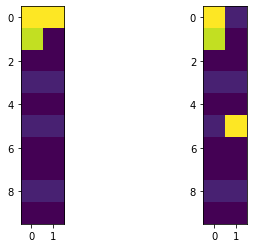

dice_number: 3  player_turn_next:  1


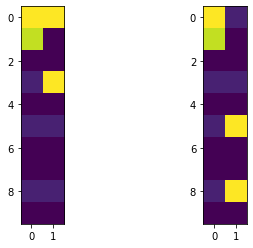

dice_number: 3  player_turn_next:  1


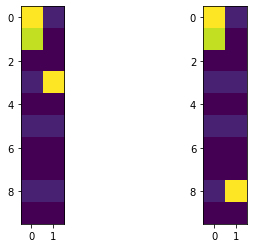

dice_number: 2  player_turn_next:  0


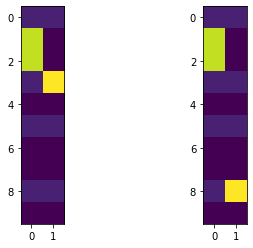

dice_number: 2  player_turn_next:  1


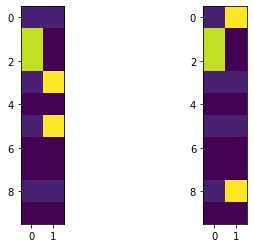

dice_number: 3  player_turn_next:  0


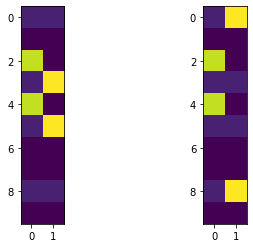

dice_number: 2  player_turn_next:  0


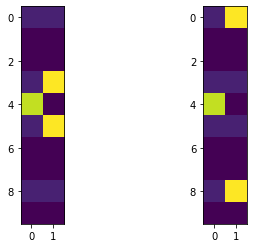

dice_number: 3  player_turn_next:  1


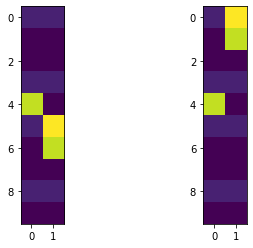

dice_number: 2  player_turn_next:  1


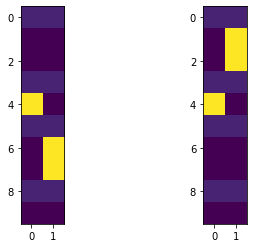

dice_number: 2  player_turn_next:  0


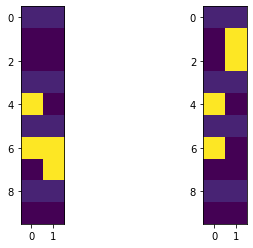

dice_number: 3  player_turn_next:  1
BOOM


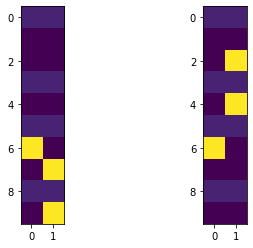

dice_number: 2  player_turn_next:  1


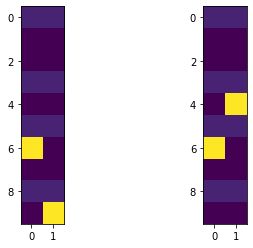

dice_number: 2  player_turn_next:  0


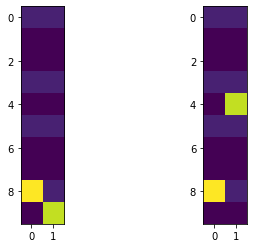

dice_number: 3  player_turn_next:  1


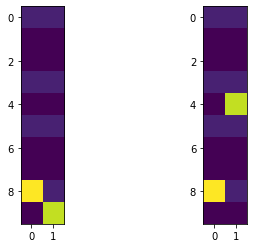

dice_number: 3  player_turn_next:  1


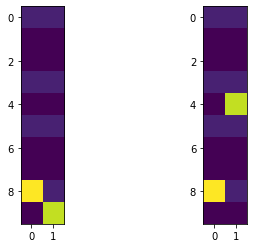

dice_number: 2  player_turn_next:  0


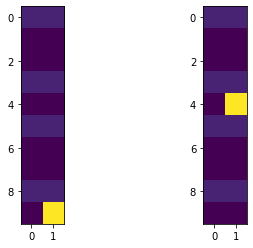

dice_number: 1  player_turn_next:  0


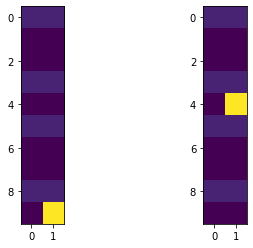

dice_number: 2  player_turn_next:  1


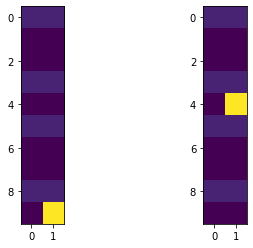

dice_number: 1  player_turn_next:  0


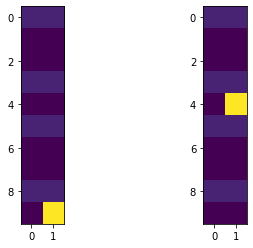

dice_number: 2  player_turn_next:  1


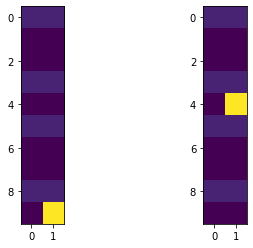

dice_number: 2  player_turn_next:  0


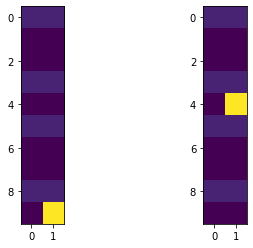

dice_number: 3  player_turn_next:  1


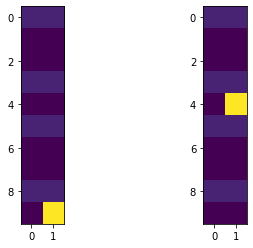

dice_number: 1  player_turn_next:  1


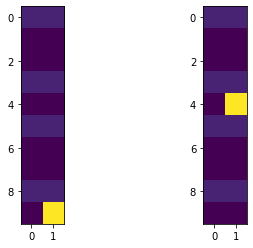

dice_number: 3  player_turn_next:  0


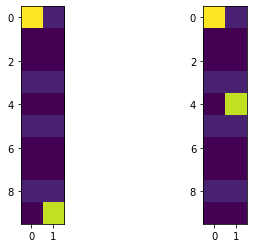

dice_number: 1  player_turn_next:  0


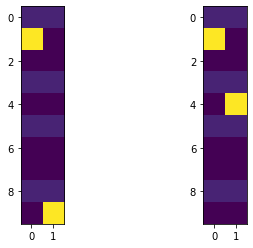

dice_number: 3  player_turn_next:  1


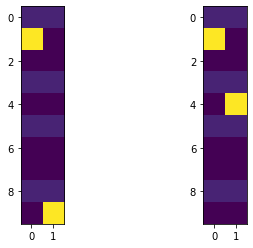

dice_number: 1  player_turn_next:  1


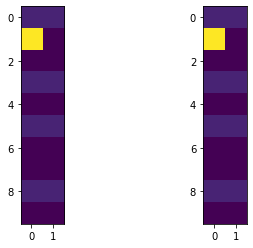

dice_number: 2  player_turn_next:  0
dice_number: 2  player_turn_next:  0


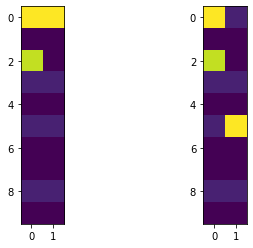

dice_number: 3  player_turn_next:  1


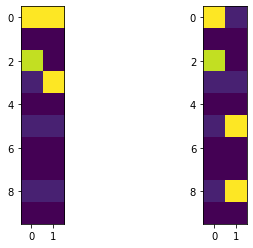

dice_number: 2  player_turn_next:  1


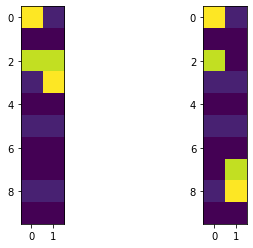

dice_number: 1  player_turn_next:  0


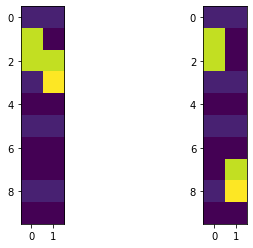

dice_number: 3  player_turn_next:  1


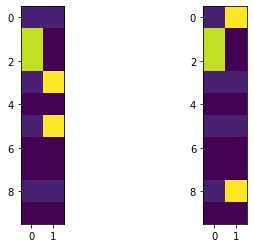

dice_number: 2  player_turn_next:  1


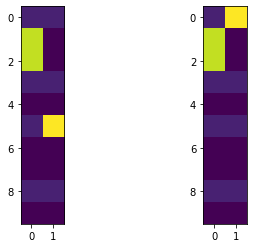

dice_number: 2  player_turn_next:  0


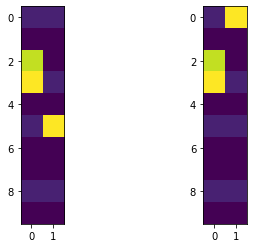

dice_number: 3  player_turn_next:  1


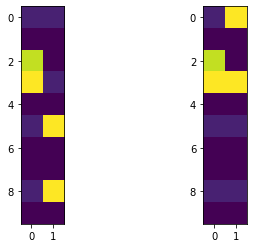

dice_number: 2  player_turn_next:  1
BOOM


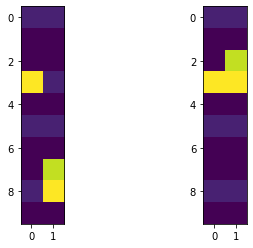

dice_number: 3  player_turn_next:  0


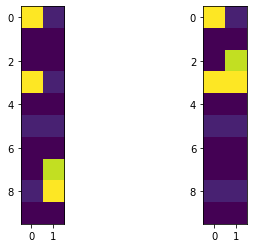

dice_number: 2  player_turn_next:  0
BOOM


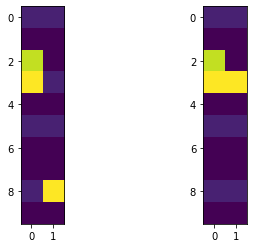

dice_number: 1  player_turn_next:  1


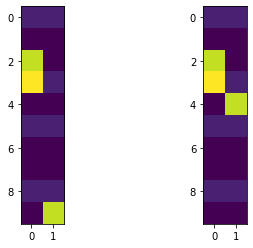

dice_number: 1  player_turn_next:  0


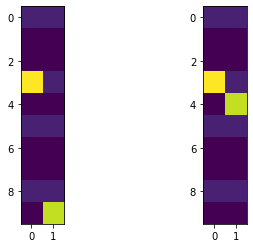

dice_number: 1  player_turn_next:  1


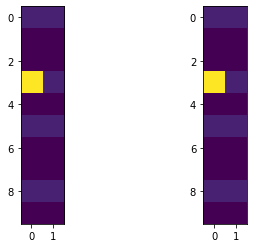

dice_number: 3  player_turn_next:  1


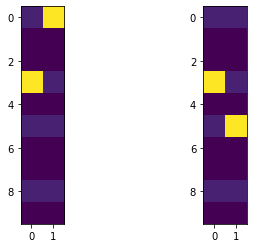

dice_number: 1  player_turn_next:  0


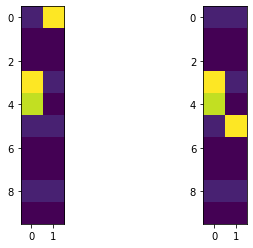

dice_number: 2  player_turn_next:  1


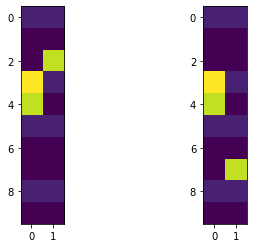

dice_number: 3  player_turn_next:  0


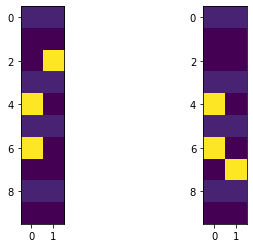

dice_number: 2  player_turn_next:  0


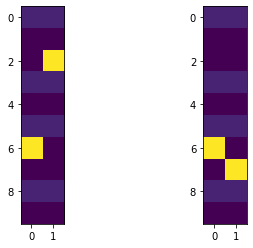

dice_number: 2  player_turn_next:  1


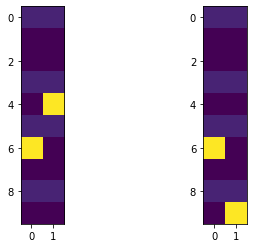

dice_number: 3  player_turn_next:  0
BOOM


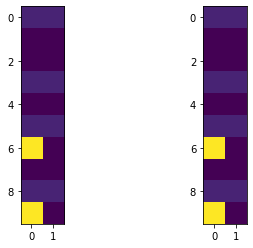

dice_number: 2  player_turn_next:  0


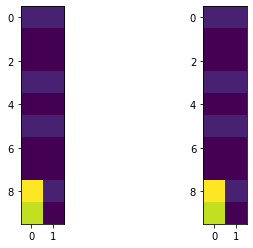

dice_number: 3  player_turn_next:  1


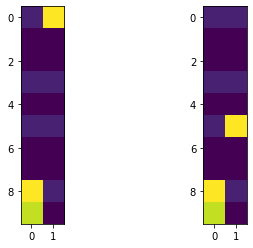

dice_number: 3  player_turn_next:  1


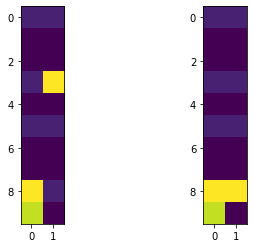

dice_number: 2  player_turn_next:  0


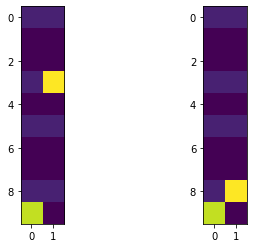

dice_number: 2  player_turn_next:  0


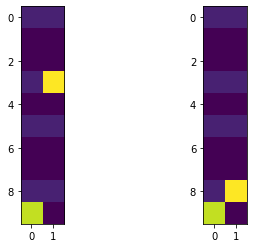

dice_number: 3  player_turn_next:  1


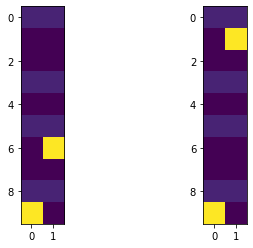

dice_number: 1  player_turn_next:  1


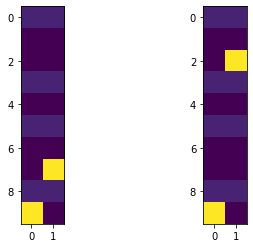

dice_number: 1  player_turn_next:  0


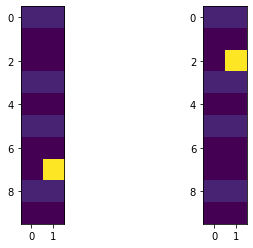

dice_number: 2  player_turn_next:  0
dice_number: 2  player_turn_next:  0


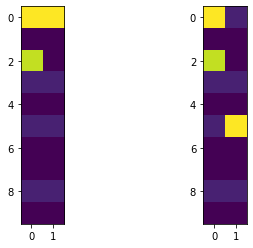

dice_number: 1  player_turn_next:  1


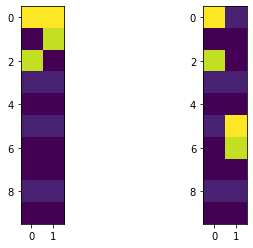

dice_number: 1  player_turn_next:  0


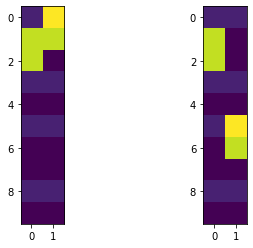

dice_number: 1  player_turn_next:  1


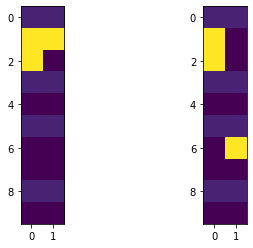

dice_number: 3  player_turn_next:  0


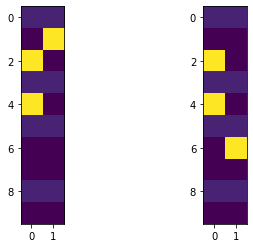

dice_number: 3  player_turn_next:  0


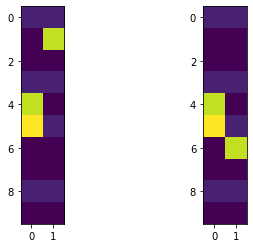

dice_number: 1  player_turn_next:  1


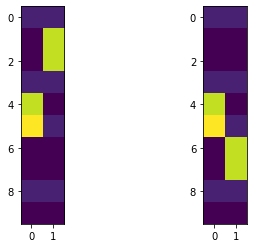

dice_number: 1  player_turn_next:  0


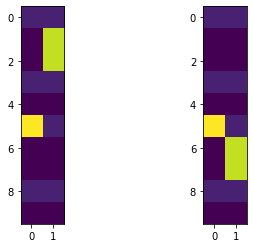

dice_number: 2  player_turn_next:  1


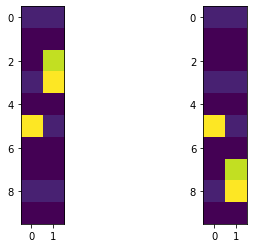

dice_number: 3  player_turn_next:  0


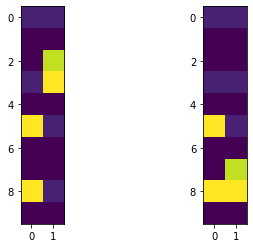

dice_number: 3  player_turn_next:  0


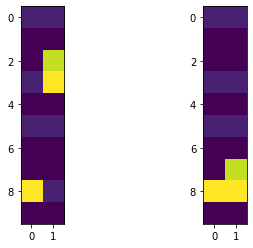

dice_number: 2  player_turn_next:  1


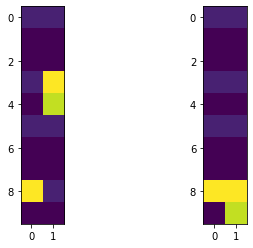

dice_number: 1  player_turn_next:  0
BOOM


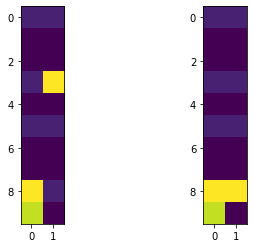

dice_number: 3  player_turn_next:  0


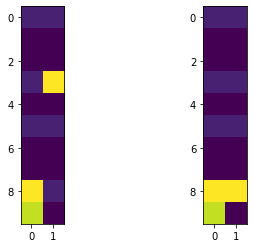

dice_number: 3  player_turn_next:  1


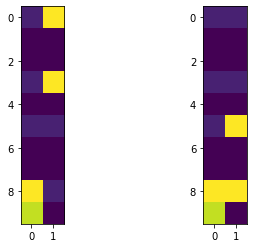

dice_number: 2  player_turn_next:  1


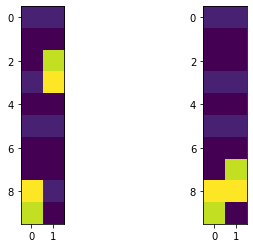

dice_number: 2  player_turn_next:  0


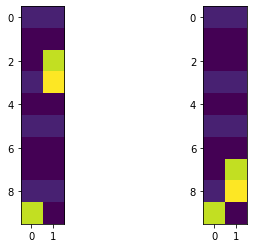

dice_number: 1  player_turn_next:  0


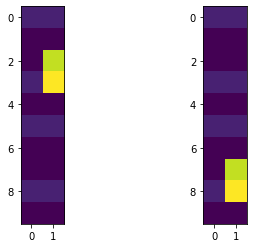

dice_number: 3  player_turn_next:  1
dice_number: 2  player_turn_next:  0


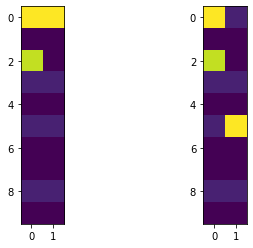

dice_number: 1  player_turn_next:  1


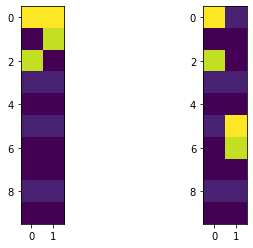

dice_number: 2  player_turn_next:  0


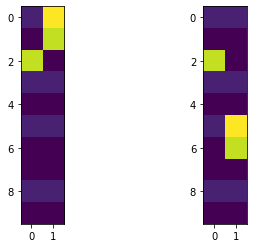

dice_number: 2  player_turn_next:  1


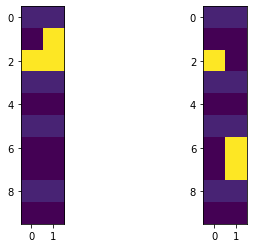

dice_number: 3  player_turn_next:  0


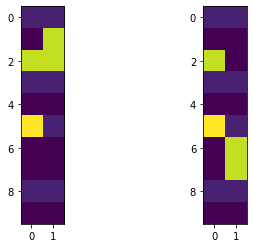

dice_number: 1  player_turn_next:  0
BOOM


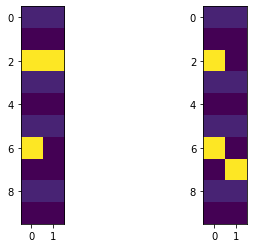

dice_number: 2  player_turn_next:  1


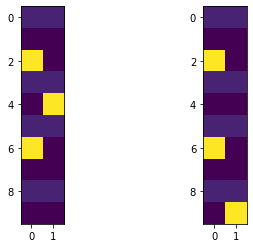

dice_number: 3  player_turn_next:  0


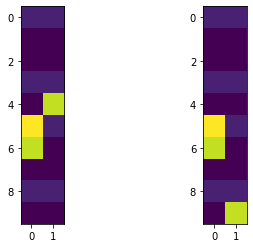

dice_number: 2  player_turn_next:  0


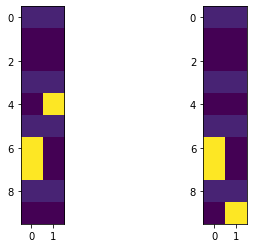

dice_number: 1  player_turn_next:  1


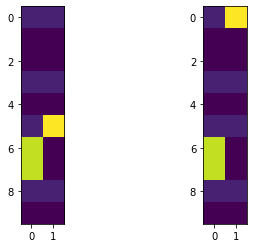

dice_number: 1  player_turn_next:  0


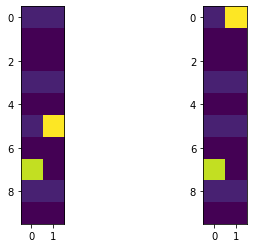

dice_number: 2  player_turn_next:  1


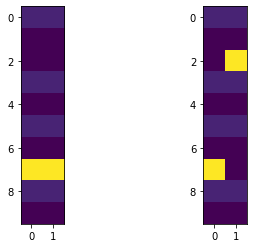

dice_number: 3  player_turn_next:  0


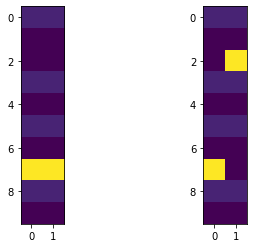

dice_number: 3  player_turn_next:  0


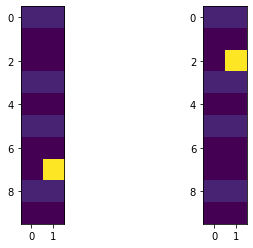

dice_number: 1  player_turn_next:  1
dice_number: 3  player_turn_next:  0


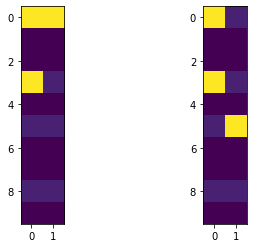

dice_number: 3  player_turn_next:  0


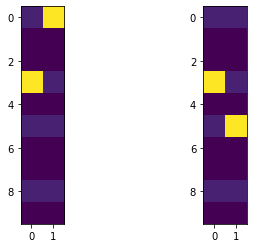

dice_number: 2  player_turn_next:  1


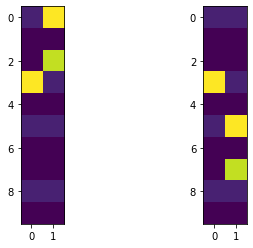

dice_number: 1  player_turn_next:  0


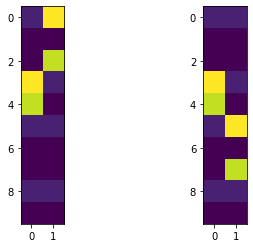

dice_number: 2  player_turn_next:  1


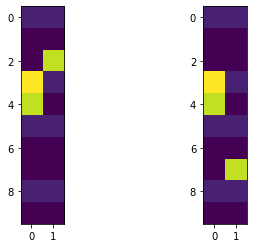

dice_number: 1  player_turn_next:  0


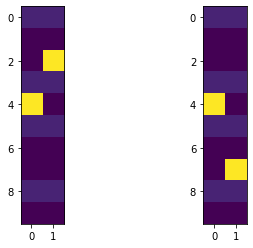

dice_number: 2  player_turn_next:  1


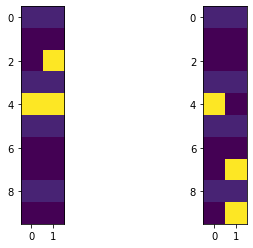

dice_number: 3  player_turn_next:  0
BOOM


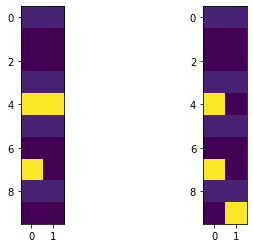

dice_number: 3  player_turn_next:  0


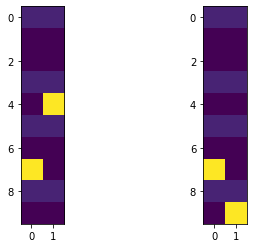

dice_number: 2  player_turn_next:  1


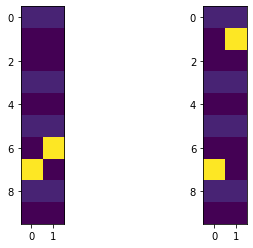

dice_number: 2  player_turn_next:  0


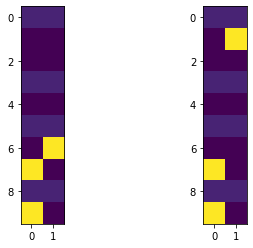

dice_number: 2  player_turn_next:  1


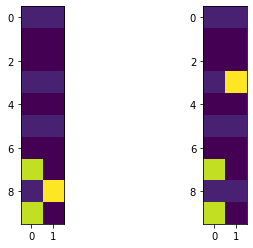

dice_number: 2  player_turn_next:  0


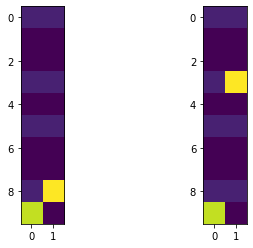

dice_number: 1  player_turn_next:  1


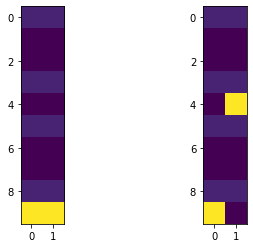

dice_number: 1  player_turn_next:  0


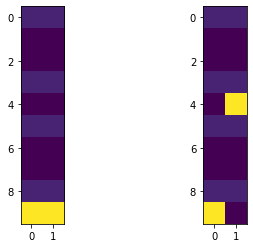

dice_number: 2  player_turn_next:  0


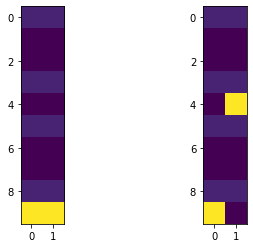

dice_number: 3  player_turn_next:  1


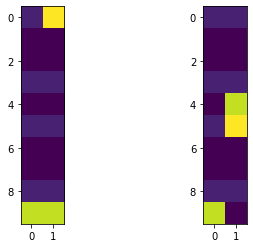

dice_number: 2  player_turn_next:  1


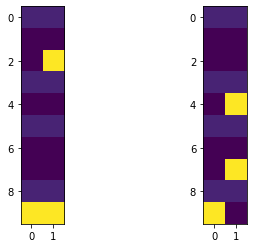

dice_number: 1  player_turn_next:  0


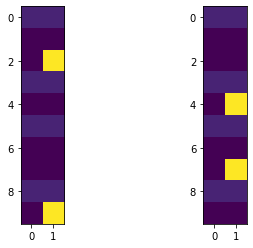

dice_number: 2  player_turn_next:  0
dice_number: 2  player_turn_next:  0


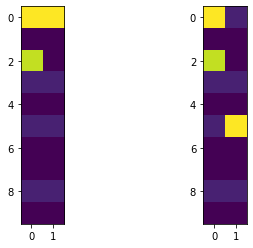

dice_number: 3  player_turn_next:  1


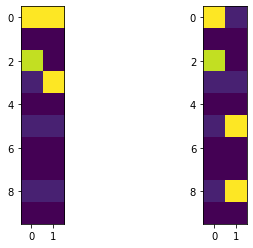

dice_number: 3  player_turn_next:  1


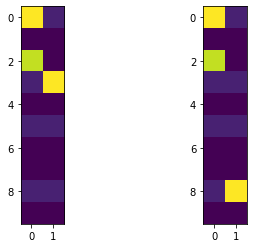

dice_number: 1  player_turn_next:  0


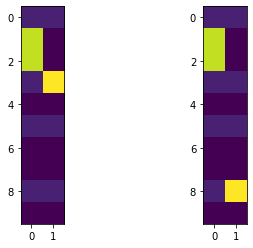

dice_number: 3  player_turn_next:  1
BOOM


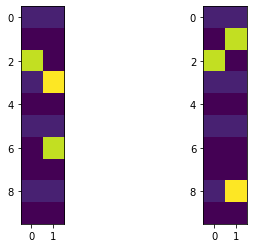

dice_number: 2  player_turn_next:  1


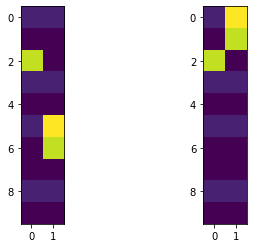

dice_number: 3  player_turn_next:  0


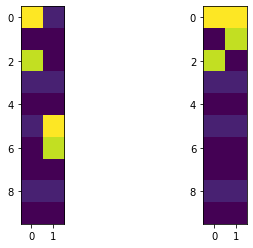

dice_number: 2  player_turn_next:  0


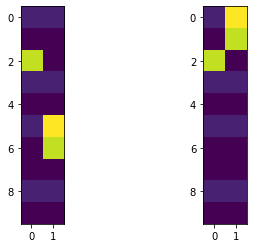

dice_number: 2  player_turn_next:  1
BOOM


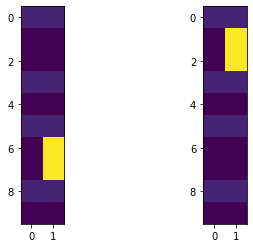

dice_number: 1  player_turn_next:  1


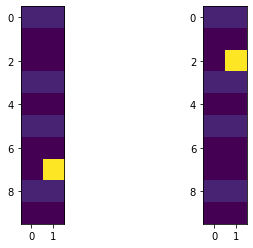

dice_number: 2  player_turn_next:  0


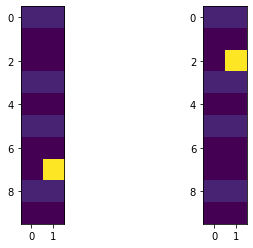

dice_number: 1  player_turn_next:  1


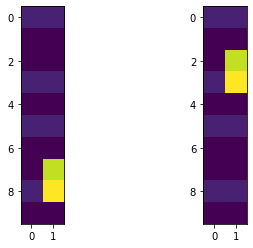

dice_number: 2  player_turn_next:  0


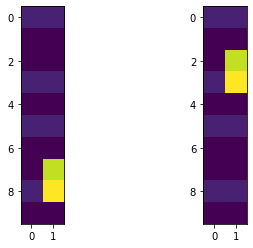

dice_number: 2  player_turn_next:  1


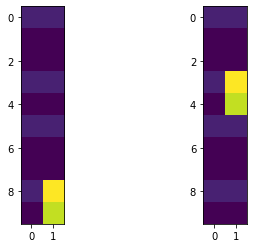

dice_number: 1  player_turn_next:  0


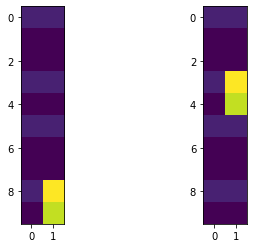

dice_number: 3  player_turn_next:  1


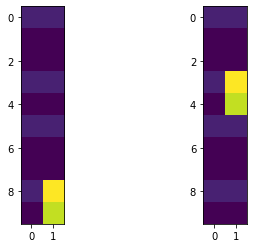

dice_number: 2  player_turn_next:  1


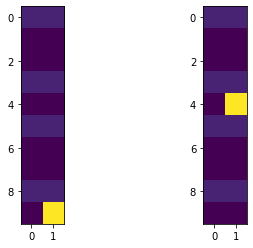

dice_number: 2  player_turn_next:  0


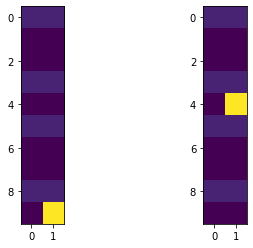

dice_number: 3  player_turn_next:  1


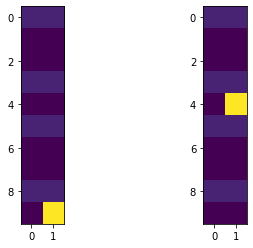

dice_number: 3  player_turn_next:  1


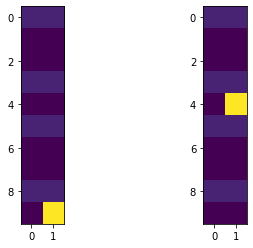

dice_number: 3  player_turn_next:  0


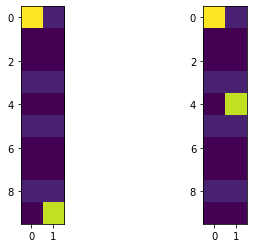

dice_number: 3  player_turn_next:  0


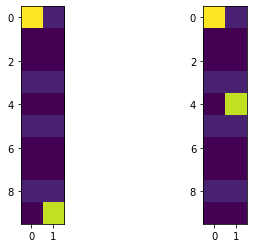

dice_number: 2  player_turn_next:  1


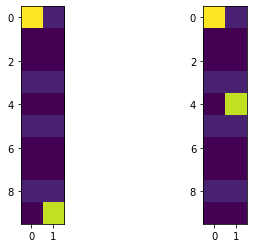

dice_number: 3  player_turn_next:  0


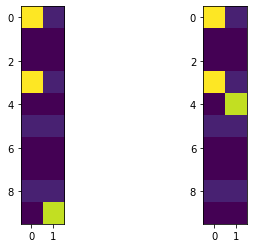

dice_number: 2  player_turn_next:  0


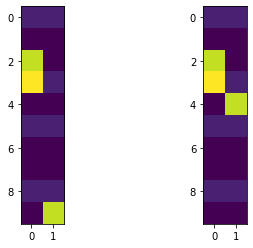

dice_number: 1  player_turn_next:  1


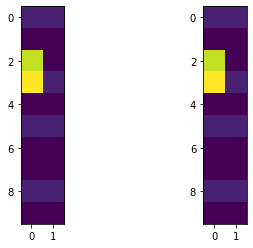

dice_number: 2  player_turn_next:  1
dice_number: 1  player_turn_next:  0


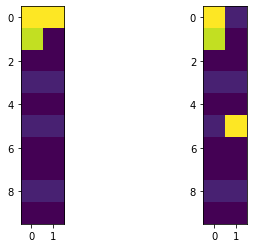

dice_number: 3  player_turn_next:  1


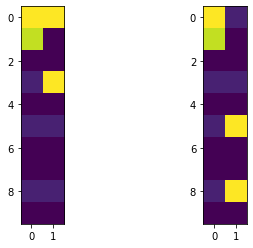

dice_number: 1  player_turn_next:  1


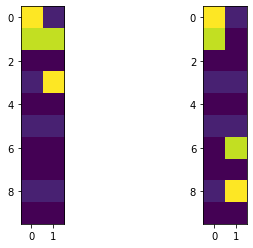

dice_number: 2  player_turn_next:  0


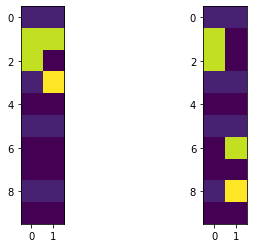

dice_number: 2  player_turn_next:  1


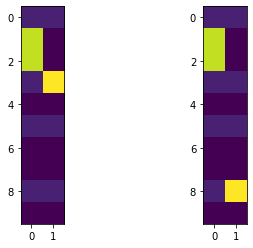

dice_number: 1  player_turn_next:  0


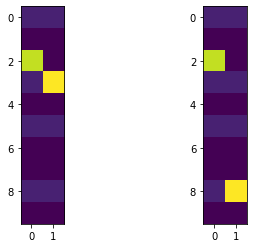

dice_number: 3  player_turn_next:  1


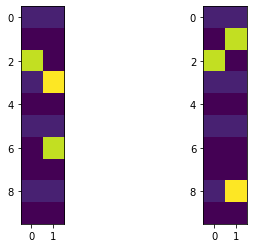

dice_number: 3  player_turn_next:  1


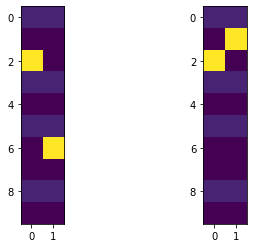

dice_number: 1  player_turn_next:  0


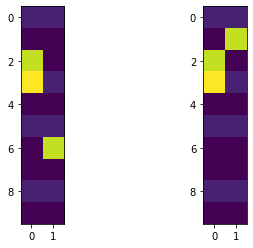

dice_number: 1  player_turn_next:  1
BOOM


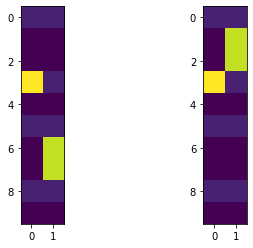

dice_number: 1  player_turn_next:  1


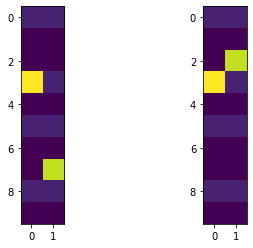

dice_number: 3  player_turn_next:  0


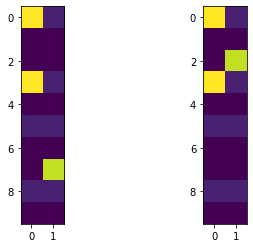

dice_number: 2  player_turn_next:  0
BOOM


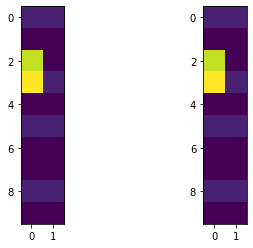

dice_number: 1  player_turn_next:  1


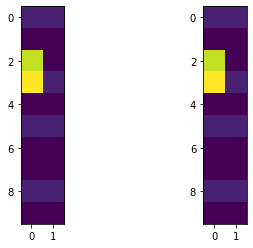

dice_number: 2  player_turn_next:  0


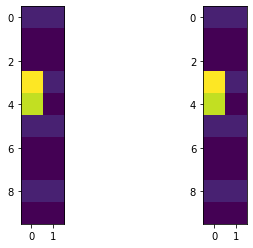

dice_number: 2  player_turn_next:  1


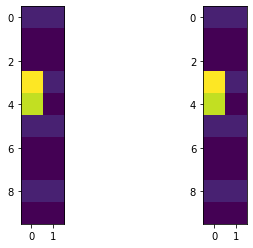

dice_number: 2  player_turn_next:  0


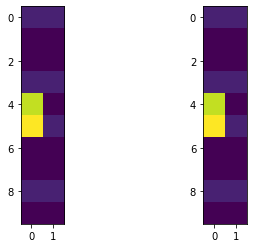

dice_number: 2  player_turn_next:  1


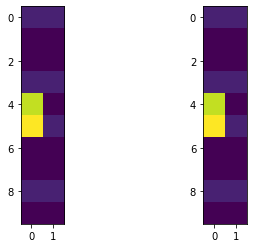

dice_number: 3  player_turn_next:  0


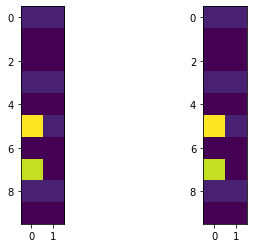

dice_number: 1  player_turn_next:  0


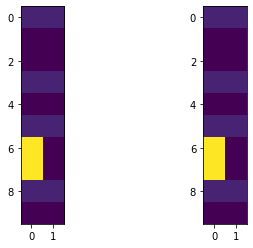

dice_number: 1  player_turn_next:  1


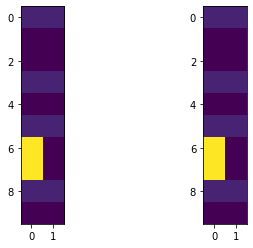

dice_number: 2  player_turn_next:  0


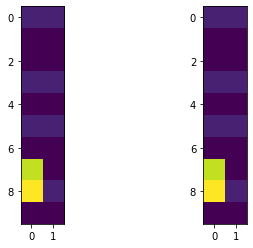

dice_number: 1  player_turn_next:  1


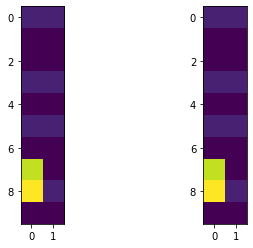

dice_number: 3  player_turn_next:  0


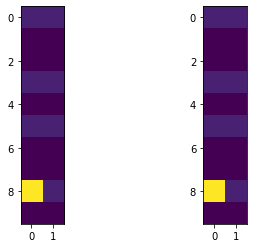

dice_number: 1  player_turn_next:  0


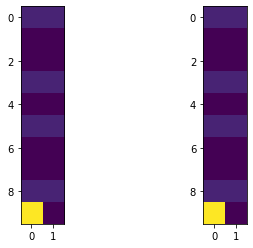

dice_number: 3  player_turn_next:  1


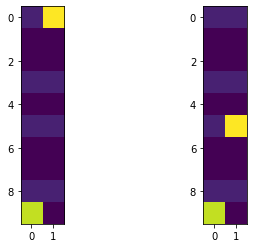

dice_number: 2  player_turn_next:  1


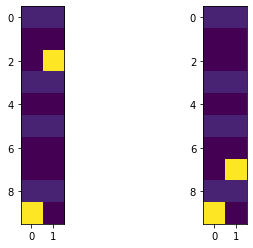

dice_number: 1  player_turn_next:  0


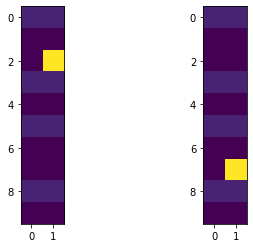

dice_number: 1  player_turn_next:  0
dice_number: 2  player_turn_next:  0


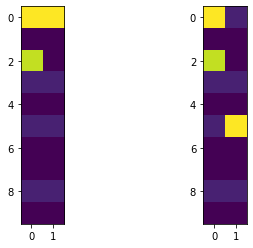

dice_number: 3  player_turn_next:  1


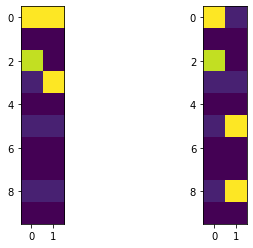

dice_number: 2  player_turn_next:  1


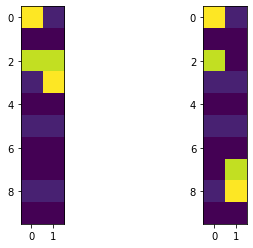

dice_number: 2  player_turn_next:  0


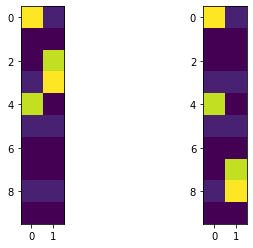

dice_number: 2  player_turn_next:  1


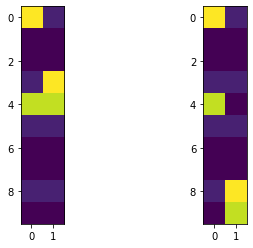

dice_number: 1  player_turn_next:  0


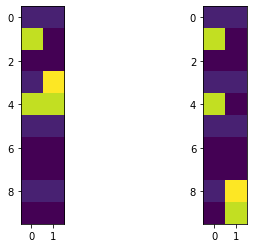

dice_number: 3  player_turn_next:  1
BOOM


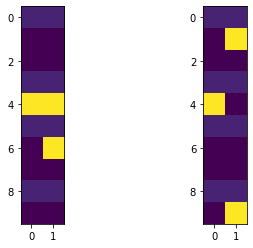

dice_number: 3  player_turn_next:  1


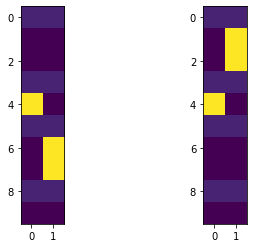

dice_number: 1  player_turn_next:  0


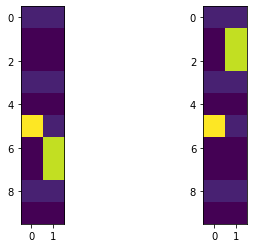

dice_number: 1  player_turn_next:  1


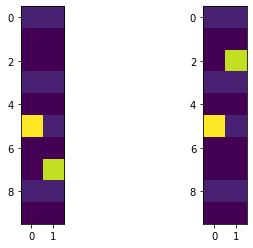

dice_number: 1  player_turn_next:  0


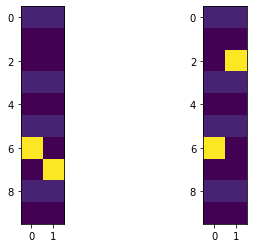

dice_number: 1  player_turn_next:  1


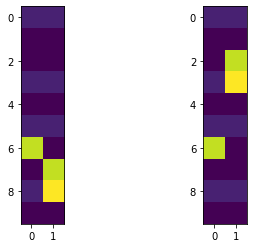

dice_number: 1  player_turn_next:  0


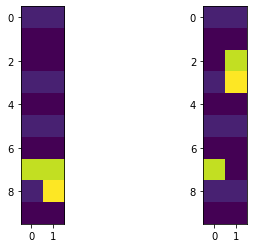

dice_number: 2  player_turn_next:  1


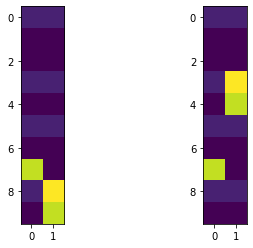

dice_number: 3  player_turn_next:  0


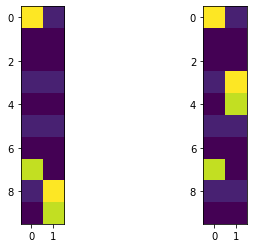

dice_number: 3  player_turn_next:  0


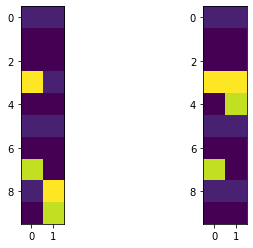

dice_number: 2  player_turn_next:  1


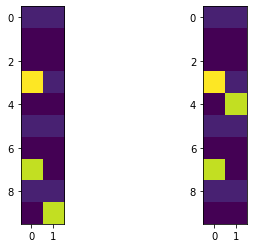

dice_number: 3  player_turn_next:  1


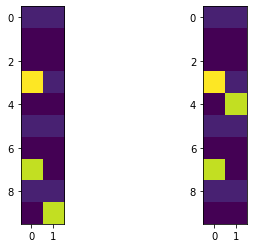

dice_number: 3  player_turn_next:  0


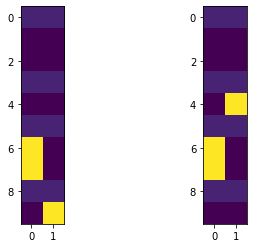

dice_number: 2  player_turn_next:  0


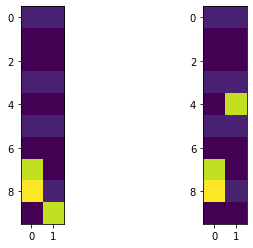

dice_number: 1  player_turn_next:  1


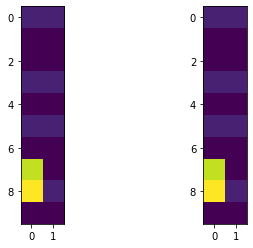

dice_number: 1  player_turn_next:  1
dice_number: 1  player_turn_next:  0


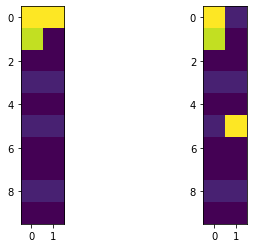

dice_number: 1  player_turn_next:  1


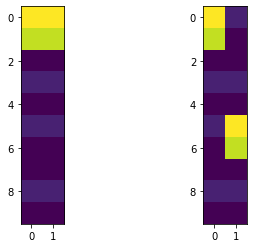

dice_number: 1  player_turn_next:  0


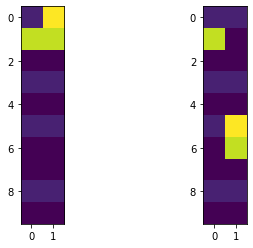

dice_number: 3  player_turn_next:  1


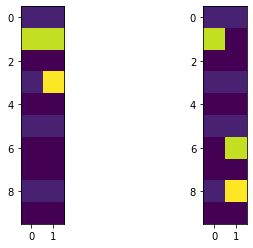

dice_number: 1  player_turn_next:  1


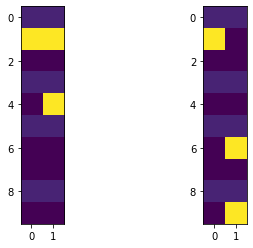

dice_number: 3  player_turn_next:  0


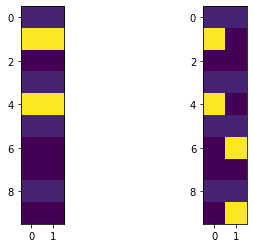

dice_number: 3  player_turn_next:  0


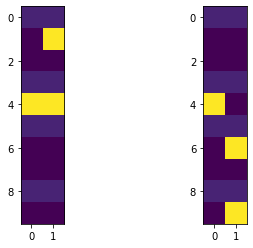

dice_number: 3  player_turn_next:  1


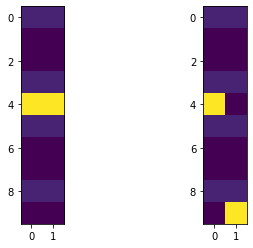

dice_number: 2  player_turn_next:  1


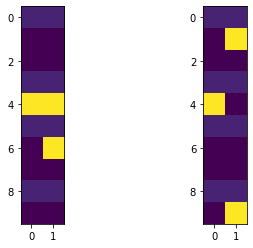

dice_number: 3  player_turn_next:  0


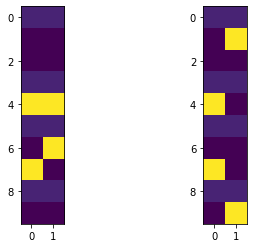

dice_number: 1  player_turn_next:  0


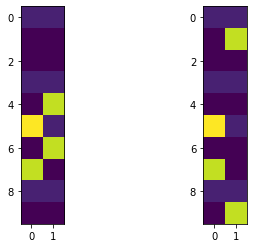

dice_number: 3  player_turn_next:  1


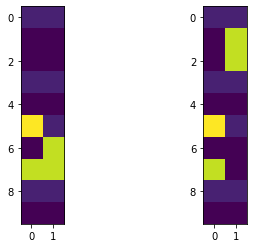

dice_number: 2  player_turn_next:  1


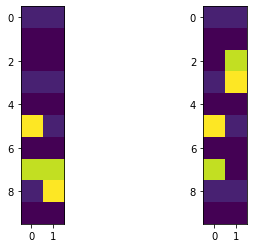

dice_number: 1  player_turn_next:  0


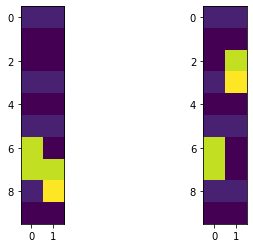

dice_number: 3  player_turn_next:  1


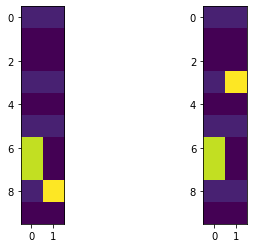

dice_number: 2  player_turn_next:  1


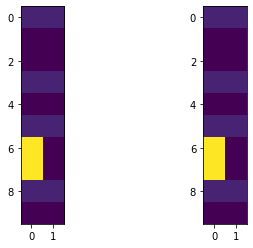

dice_number: 1  player_turn_next:  0
dice_number: 1  player_turn_next:  0


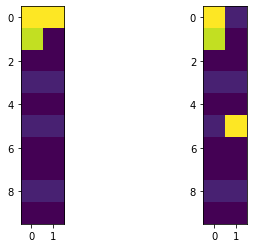

dice_number: 3  player_turn_next:  1


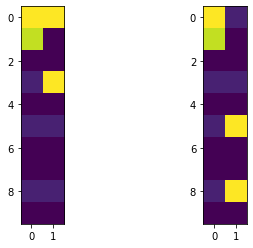

dice_number: 3  player_turn_next:  1
BOOM


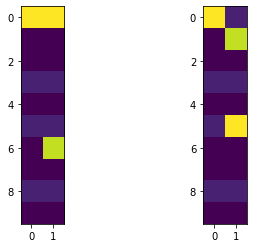

dice_number: 3  player_turn_next:  0


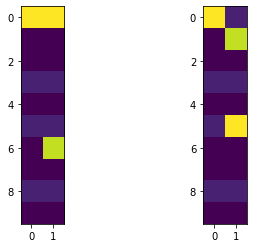

dice_number: 3  player_turn_next:  0


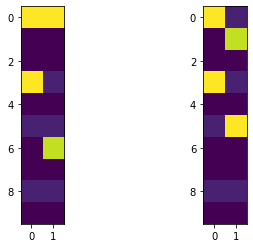

dice_number: 1  player_turn_next:  1


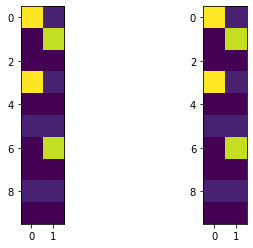

dice_number: 2  player_turn_next:  0


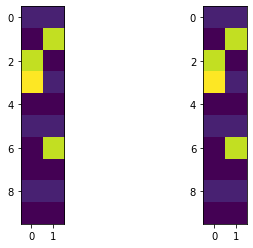

dice_number: 3  player_turn_next:  1


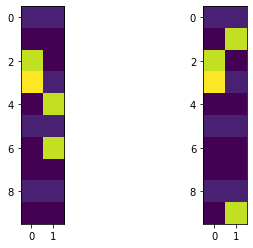

dice_number: 3  player_turn_next:  1
BOOM


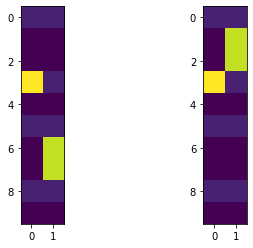

dice_number: 2  player_turn_next:  0


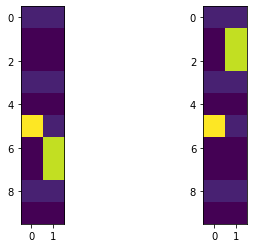

dice_number: 2  player_turn_next:  1


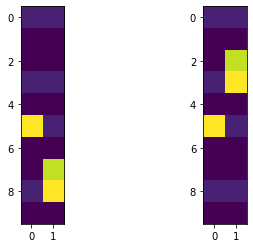

dice_number: 1  player_turn_next:  0


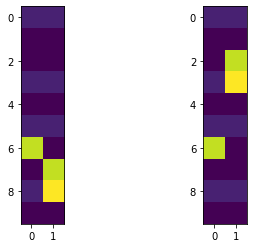

dice_number: 3  player_turn_next:  1


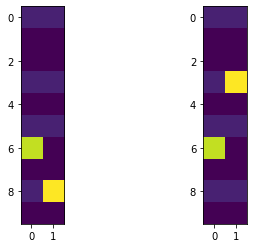

dice_number: 1  player_turn_next:  1


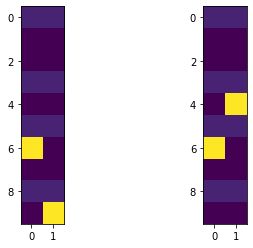

dice_number: 2  player_turn_next:  0


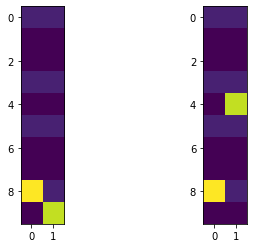

dice_number: 2  player_turn_next:  1


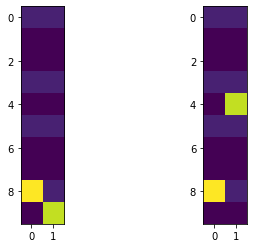

dice_number: 1  player_turn_next:  0


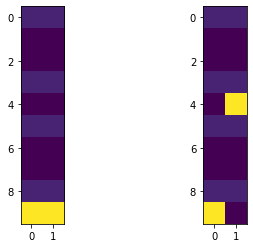

dice_number: 2  player_turn_next:  1


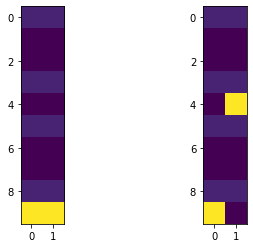

dice_number: 1  player_turn_next:  0


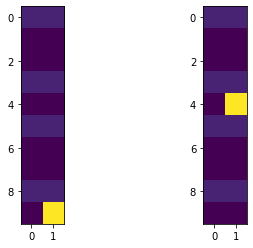

dice_number: 1  player_turn_next:  0


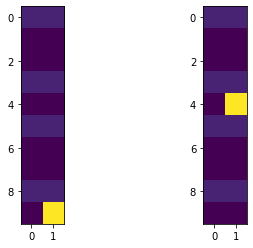

dice_number: 1  player_turn_next:  1


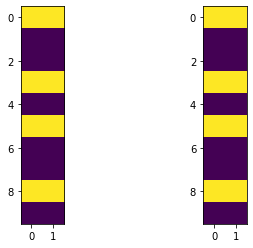

dice_number: 3  player_turn_next:  1


In [ ]:
# import time
env.verbose = True
for episode in range(10):
    observation = env.reset()
    
    positions_all, dice_face, player_turn, moves_left = observation
    print('dice_number:', dice_face, ' player_turn_next: ',player_turn)
    
    positions_adjusted = positions_all[player_turn*env.NUM_PIECES:] + positions_all[:player_turn*env.NUM_PIECES]
    
    done = False
    reward_this_ep = 0
    
    state = torch.Tensor(positions_adjusted + [dice_face -1, moves_left])
    while not done:
        
        action_p = torch.distributions.Categorical(F.softmax(actor.forward(state)))
        action = action_p.sample()
        log_p = action_p.log_prob(action)
        action = action.item()
        
        next_obs, reward, done, _ = env.step(action)
        env.render()
        
        p_all_next, dice_face_next, player_turn_next, moves_left_next = next_obs
        positions_adjusted_next = p_all_next[player_turn_next*env.NUM_PIECES:] + p_all_next[:player_turn_next*env.NUM_PIECES]
        print('dice_number:', dice_face_next, ' player_turn_next: ',player_turn_next)
        
        next_state = torch.Tensor(positions_adjusted_next + [dice_face_next-1, moves_left_next])
                    
        positions_all, dice_face, player_turn, moves_left = p_all_next, dice_face_next, player_turn_next, moves_left_next
        state = next_state
        


dice_number: 2  player_turn_next:  0


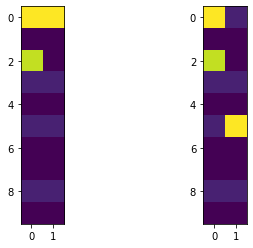

dice_number: 2  player_turn_next:  1


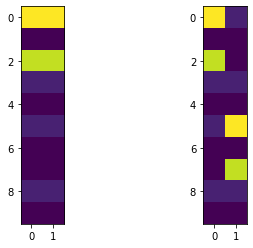

dice_number: 1  player_turn_next:  0


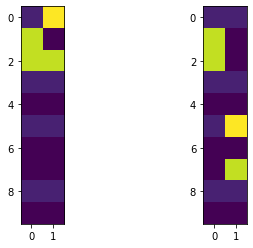

dice_number: 3  player_turn_next:  1


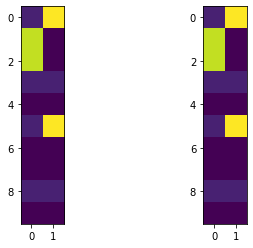

dice_number: 3  player_turn_next:  1


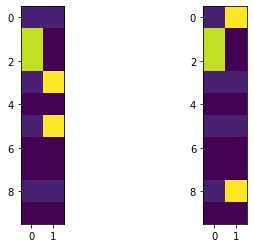

dice_number: 3  player_turn_next:  1
BOOM


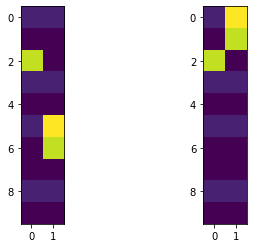

dice_number: 2  player_turn_next:  1
BOOM


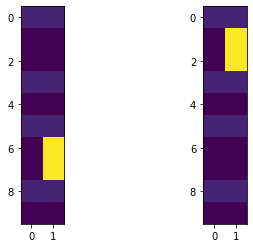

dice_number: 3  player_turn_next:  1


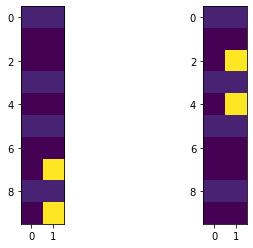

dice_number: 3  player_turn_next:  0


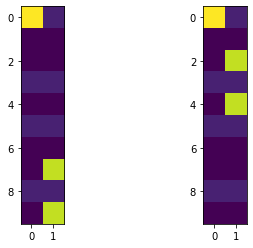

dice_number: 1  player_turn_next:  0


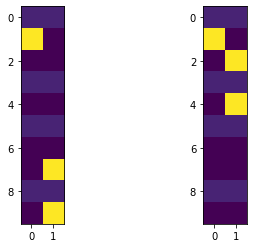

dice_number: 2  player_turn_next:  1


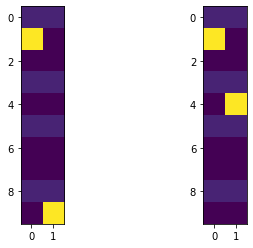

dice_number: 3  player_turn_next:  0


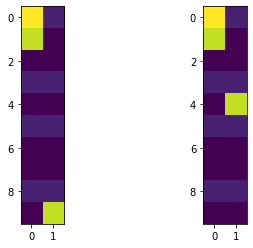

dice_number: 3  player_turn_next:  0


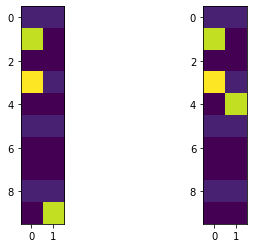

dice_number: 2  player_turn_next:  0


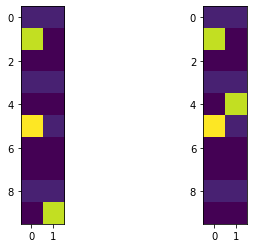

dice_number: 3  player_turn_next:  1


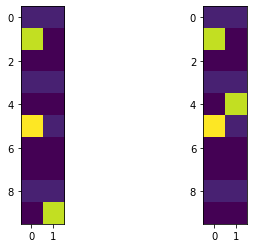

dice_number: 2  player_turn_next:  1


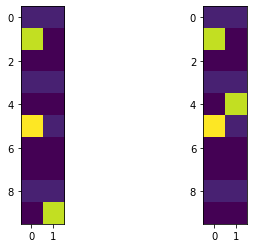

dice_number: 1  player_turn_next:  0


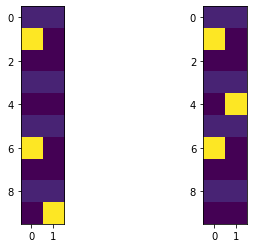

dice_number: 3  player_turn_next:  1


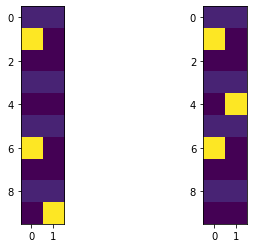

dice_number: 1  player_turn_next:  1


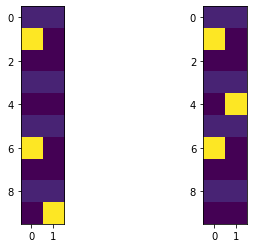

dice_number: 1  player_turn_next:  1


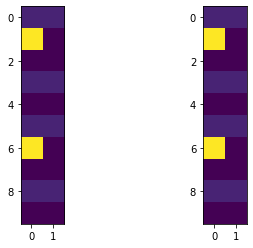

dice_number: 3  player_turn_next:  1
dice_number: 1  player_turn_next:  0


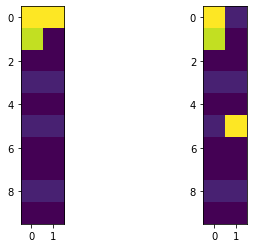

dice_number: 3  player_turn_next:  1


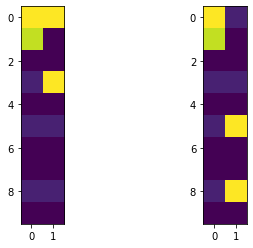

dice_number: 3  player_turn_next:  1


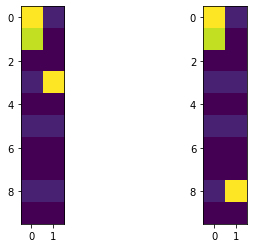

dice_number: 1  player_turn_next:  1


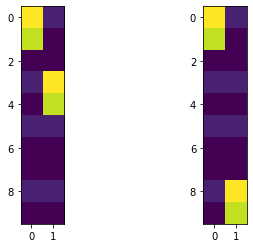

dice_number: 3  player_turn_next:  0


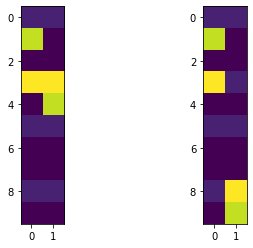

dice_number: 2  player_turn_next:  0


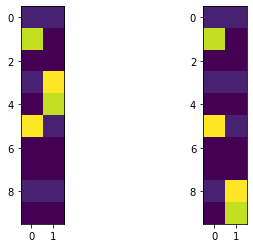

dice_number: 1  player_turn_next:  1


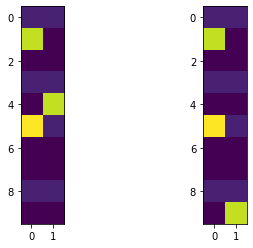

dice_number: 1  player_turn_next:  0


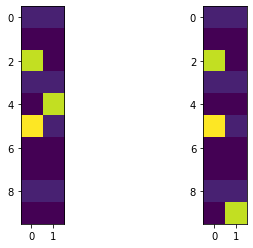

dice_number: 2  player_turn_next:  1


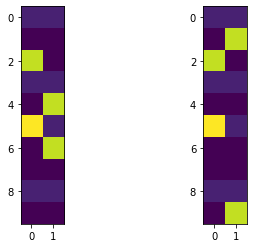

dice_number: 2  player_turn_next:  0


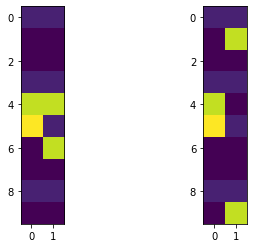

dice_number: 2  player_turn_next:  1


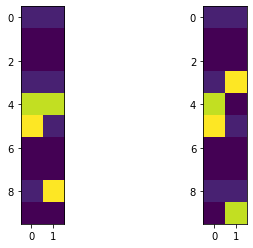

dice_number: 2  player_turn_next:  0


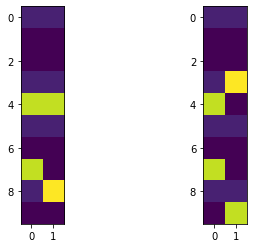

dice_number: 1  player_turn_next:  1


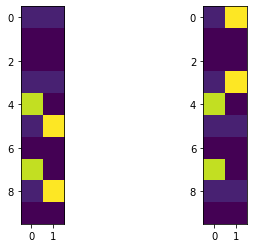

dice_number: 1  player_turn_next:  0


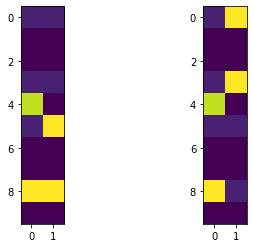

dice_number: 1  player_turn_next:  1
BOOM


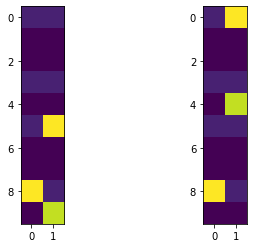

dice_number: 3  player_turn_next:  1


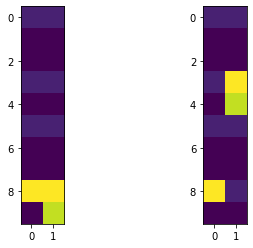

dice_number: 3  player_turn_next:  1


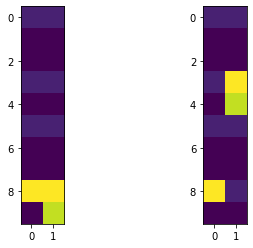

dice_number: 3  player_turn_next:  1


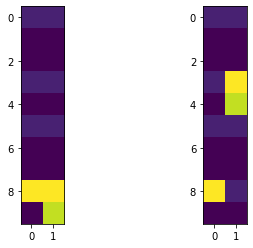

dice_number: 3  player_turn_next:  1


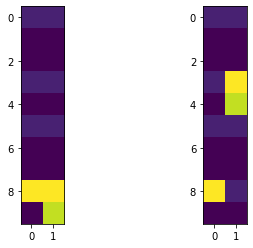

dice_number: 2  player_turn_next:  0


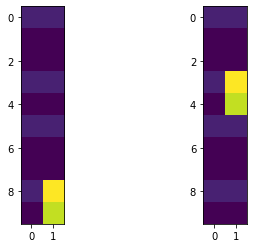

dice_number: 1  player_turn_next:  0


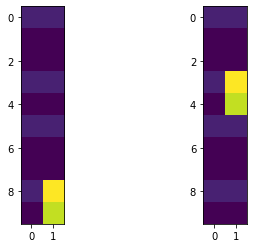

dice_number: 1  player_turn_next:  1


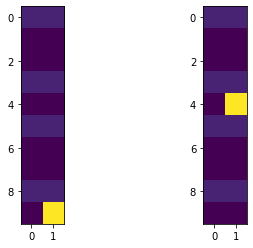

dice_number: 1  player_turn_next:  0


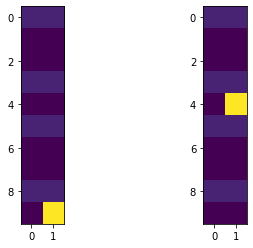

dice_number: 2  player_turn_next:  1


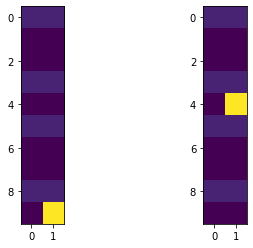

dice_number: 3  player_turn_next:  0


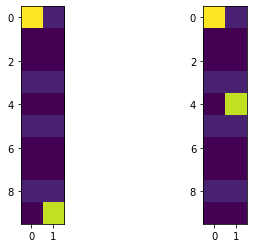

dice_number: 1  player_turn_next:  0


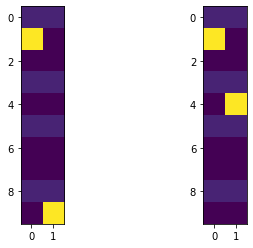

dice_number: 3  player_turn_next:  1


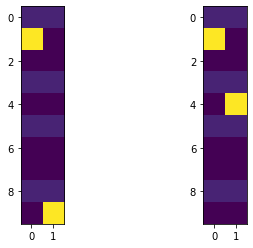

dice_number: 3  player_turn_next:  1


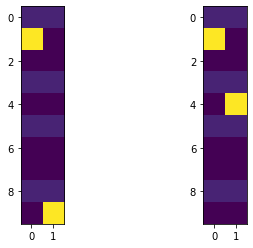

dice_number: 1  player_turn_next:  1


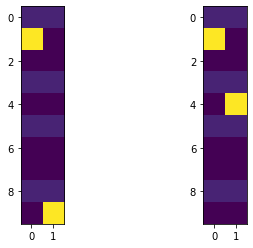

dice_number: 1  player_turn_next:  1


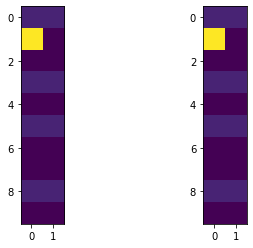

dice_number: 1  player_turn_next:  1
dice_number: 3  player_turn_next:  0


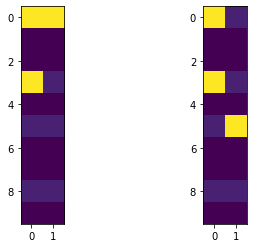

dice_number: 3  player_turn_next:  0


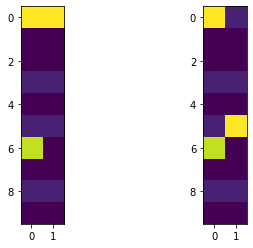

dice_number: 2  player_turn_next:  0


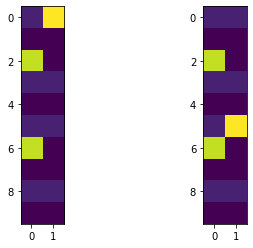

dice_number: 3  player_turn_next:  1


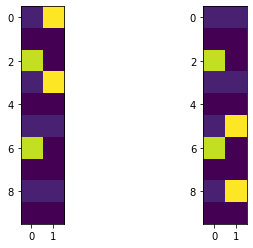

dice_number: 2  player_turn_next:  1


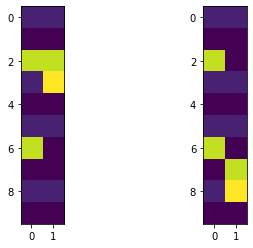

dice_number: 2  player_turn_next:  0


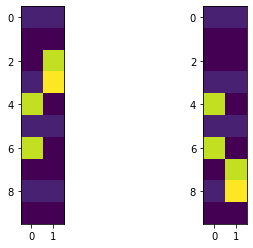

dice_number: 3  player_turn_next:  1


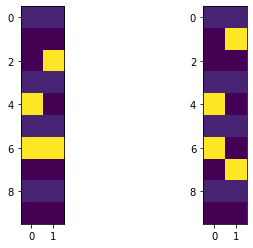

dice_number: 2  player_turn_next:  1


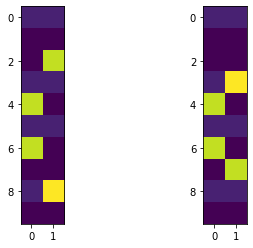

dice_number: 2  player_turn_next:  0


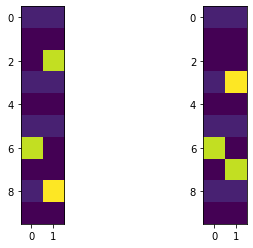

dice_number: 3  player_turn_next:  1


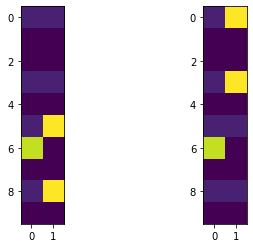

dice_number: 2  player_turn_next:  1


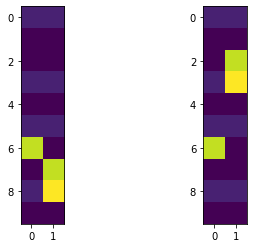

dice_number: 3  player_turn_next:  0


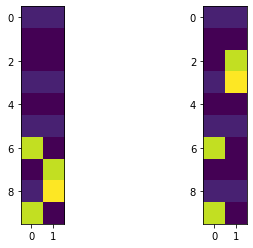

dice_number: 2  player_turn_next:  0


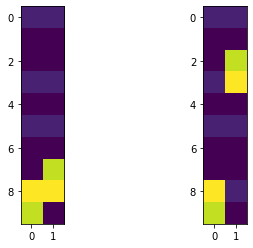

dice_number: 1  player_turn_next:  1


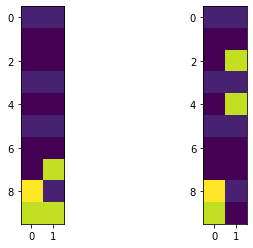

dice_number: 1  player_turn_next:  0


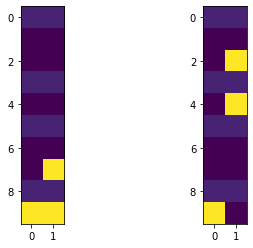

dice_number: 3  player_turn_next:  1


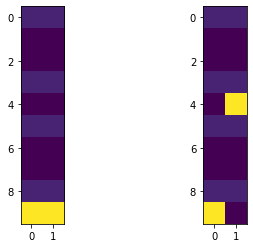

dice_number: 1  player_turn_next:  1


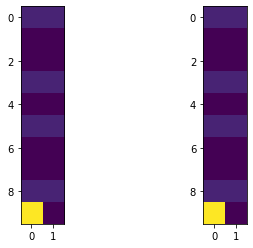

dice_number: 2  player_turn_next:  1
dice_number: 2  player_turn_next:  0


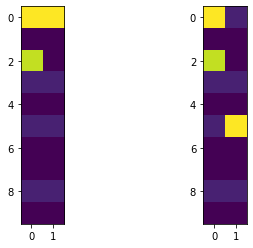

dice_number: 2  player_turn_next:  1


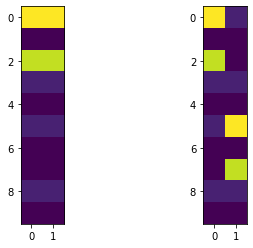

dice_number: 2  player_turn_next:  0


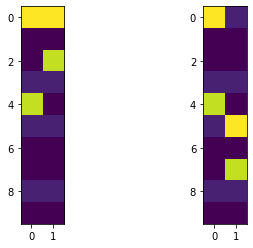

dice_number: 2  player_turn_next:  1


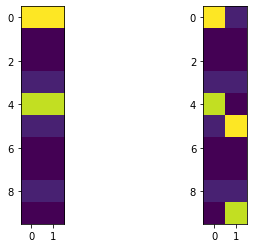

dice_number: 1  player_turn_next:  0


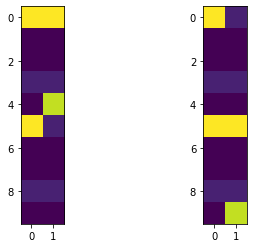

dice_number: 2  player_turn_next:  1


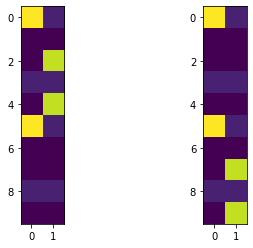

dice_number: 3  player_turn_next:  0


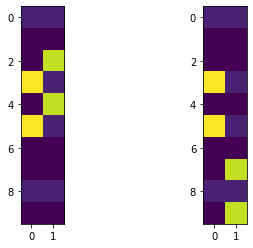

dice_number: 1  player_turn_next:  0


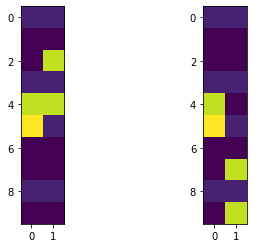

dice_number: 1  player_turn_next:  1


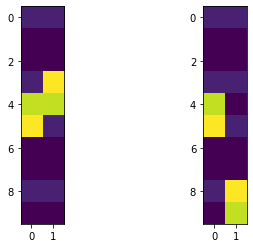

dice_number: 3  player_turn_next:  0


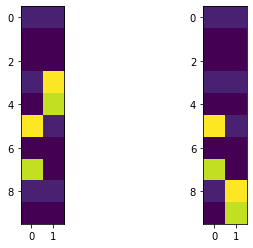

dice_number: 1  player_turn_next:  0


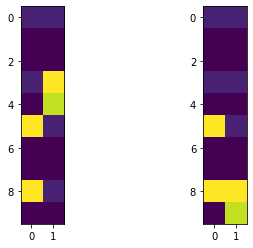

dice_number: 3  player_turn_next:  1


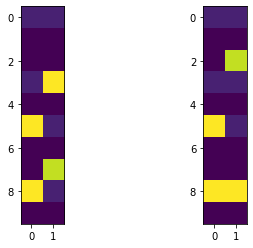

dice_number: 2  player_turn_next:  1


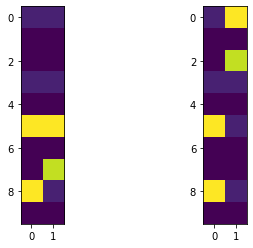

dice_number: 2  player_turn_next:  0


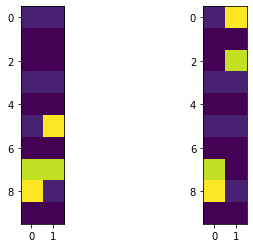

dice_number: 2  player_turn_next:  1


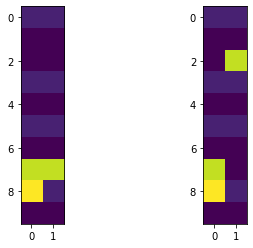

dice_number: 3  player_turn_next:  0


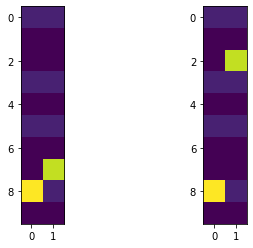

dice_number: 2  player_turn_next:  0


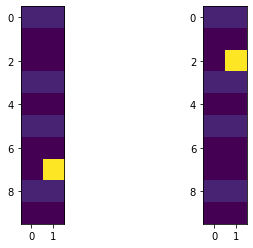

dice_number: 3  player_turn_next:  0
dice_number: 2  player_turn_next:  0


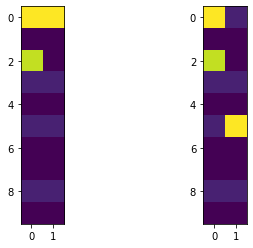

dice_number: 3  player_turn_next:  1


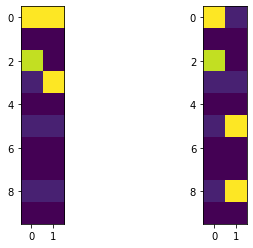

dice_number: 2  player_turn_next:  1


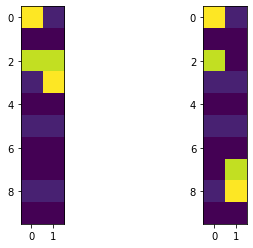

dice_number: 3  player_turn_next:  0


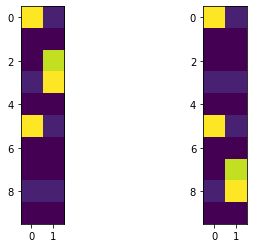

dice_number: 1  player_turn_next:  0


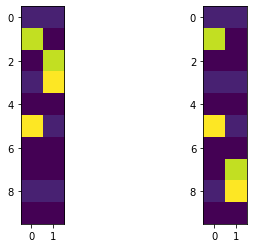

dice_number: 3  player_turn_next:  1


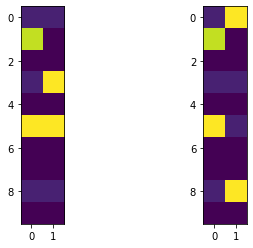

dice_number: 2  player_turn_next:  1


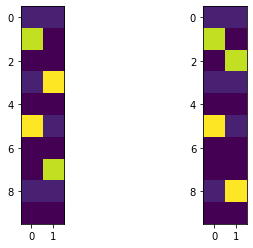

dice_number: 3  player_turn_next:  0


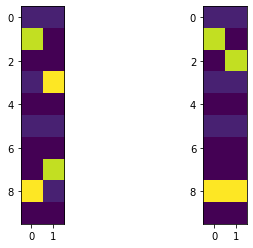

dice_number: 1  player_turn_next:  0
BOOM


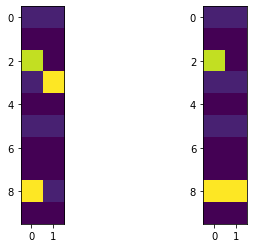

dice_number: 3  player_turn_next:  0


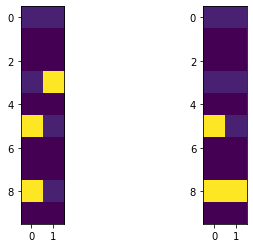

dice_number: 3  player_turn_next:  0


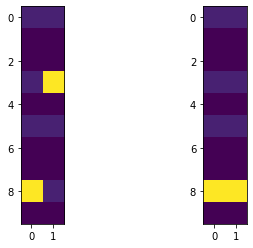

dice_number: 3  player_turn_next:  0


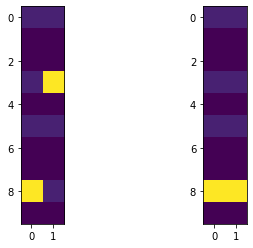

dice_number: 2  player_turn_next:  1


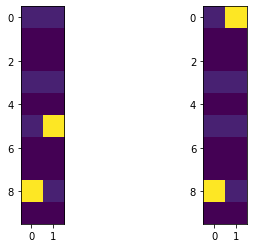

dice_number: 2  player_turn_next:  0


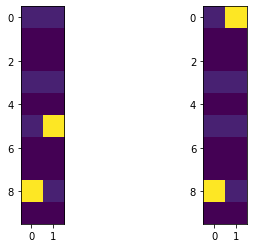

dice_number: 2  player_turn_next:  0


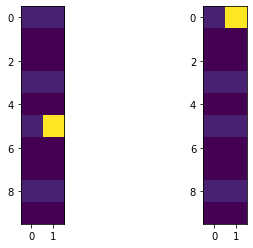

dice_number: 2  player_turn_next:  0
dice_number: 3  player_turn_next:  0


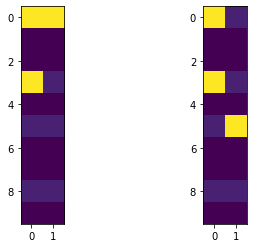

dice_number: 3  player_turn_next:  0


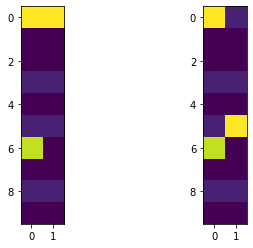

dice_number: 1  player_turn_next:  0


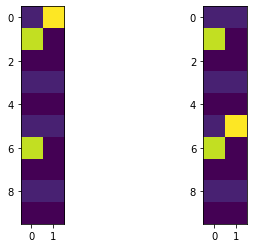

dice_number: 3  player_turn_next:  1


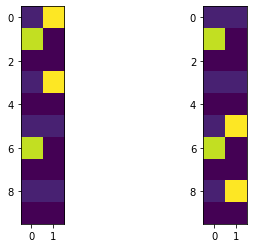

dice_number: 2  player_turn_next:  1


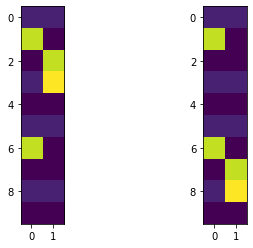

dice_number: 1  player_turn_next:  0


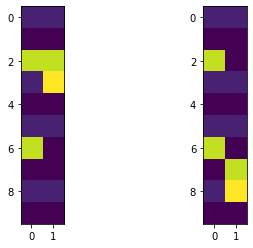

dice_number: 1  player_turn_next:  1


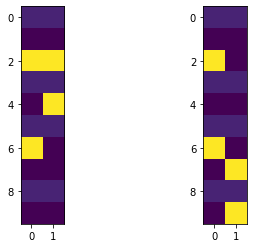

dice_number: 1  player_turn_next:  0
BOOM


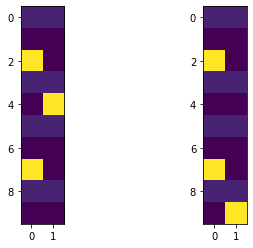

dice_number: 1  player_turn_next:  0


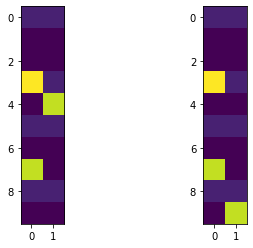

dice_number: 3  player_turn_next:  1


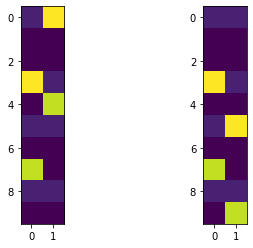

dice_number: 3  player_turn_next:  1


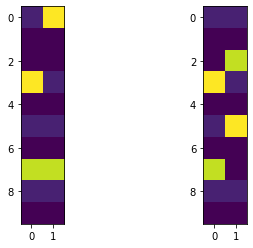

dice_number: 3  player_turn_next:  1


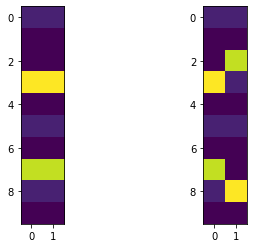

dice_number: 1  player_turn_next:  1


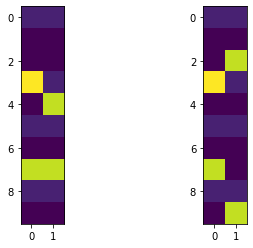

dice_number: 2  player_turn_next:  0
BOOM


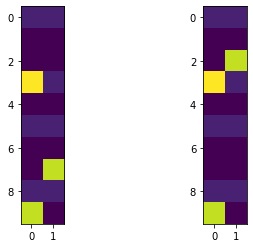

dice_number: 3  player_turn_next:  0


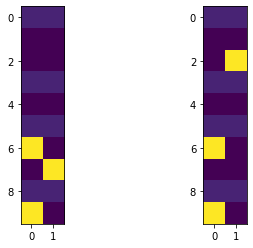

dice_number: 3  player_turn_next:  0


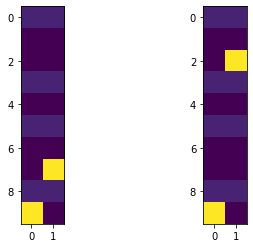

dice_number: 1  player_turn_next:  0


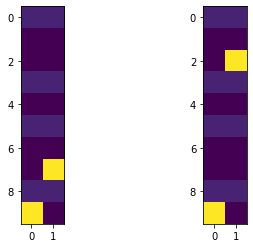

dice_number: 1  player_turn_next:  0


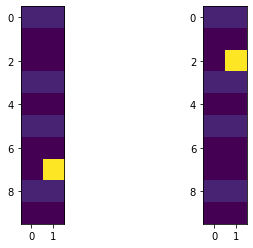

dice_number: 3  player_turn_next:  1
dice_number: 1  player_turn_next:  0


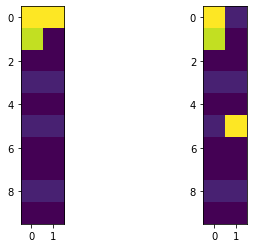

dice_number: 3  player_turn_next:  1


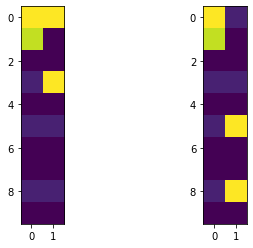

dice_number: 3  player_turn_next:  1


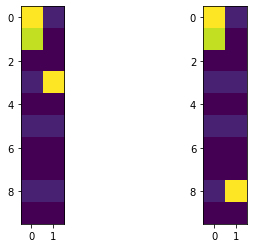

dice_number: 2  player_turn_next:  1


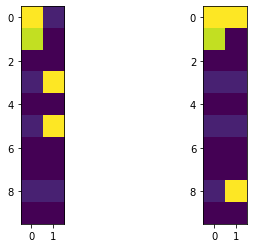

dice_number: 1  player_turn_next:  0


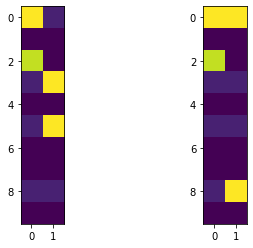

dice_number: 3  player_turn_next:  1


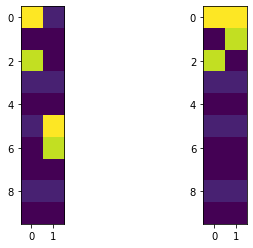

dice_number: 2  player_turn_next:  1
BOOM


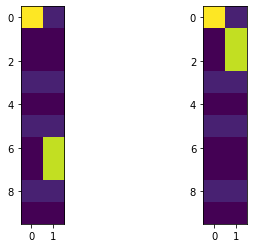

dice_number: 3  player_turn_next:  1


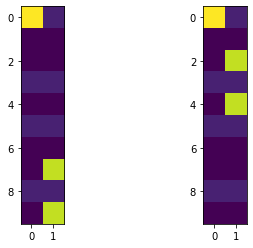

dice_number: 3  player_turn_next:  1


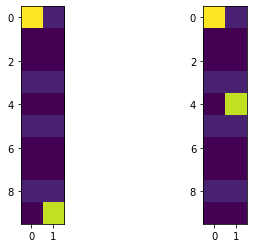

dice_number: 2  player_turn_next:  1


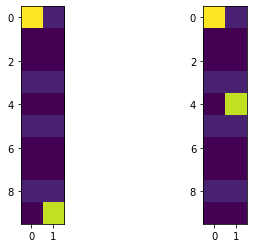

dice_number: 1  player_turn_next:  0


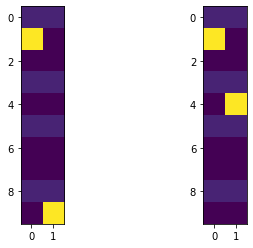

dice_number: 1  player_turn_next:  1


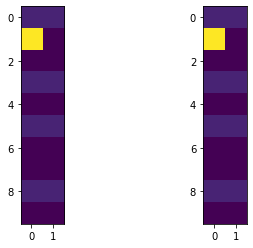

dice_number: 3  player_turn_next:  1
dice_number: 2  player_turn_next:  0


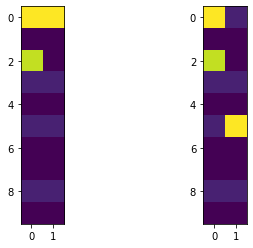

dice_number: 2  player_turn_next:  1


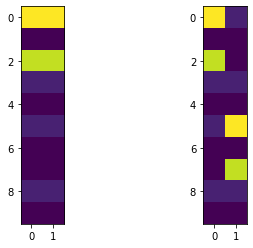

dice_number: 1  player_turn_next:  0


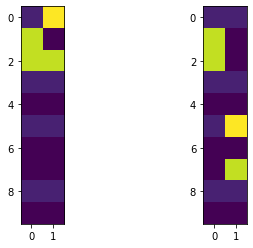

dice_number: 3  player_turn_next:  1


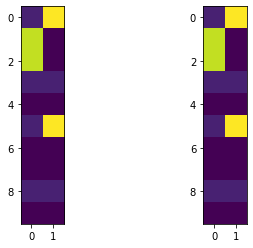

dice_number: 1  player_turn_next:  1


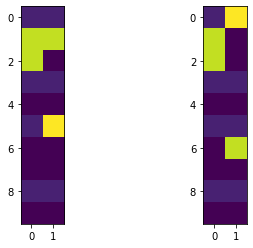

dice_number: 2  player_turn_next:  0


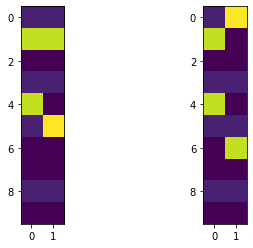

dice_number: 2  player_turn_next:  1


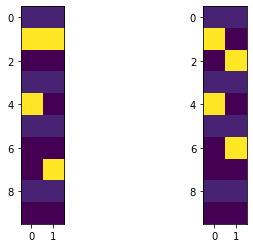

dice_number: 2  player_turn_next:  0
BOOM


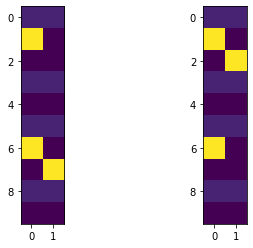

dice_number: 3  player_turn_next:  0


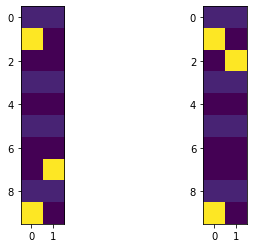

dice_number: 2  player_turn_next:  0


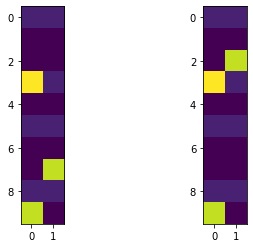

dice_number: 3  player_turn_next:  1


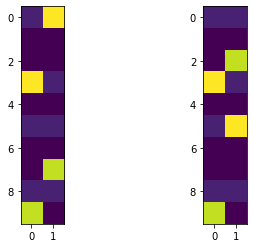

dice_number: 3  player_turn_next:  1


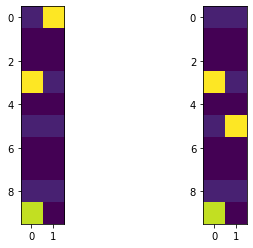

dice_number: 3  player_turn_next:  1


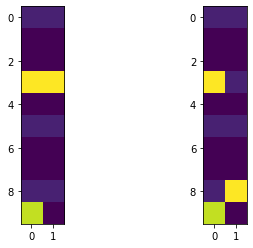

dice_number: 3  player_turn_next:  1


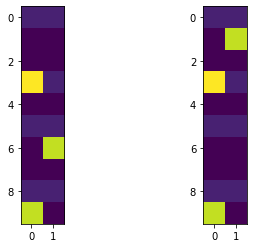

dice_number: 1  player_turn_next:  1


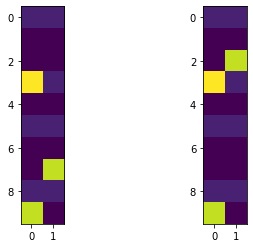

dice_number: 3  player_turn_next:  0


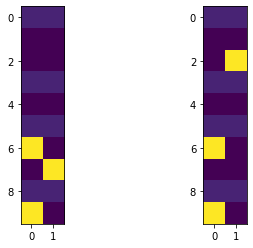

dice_number: 3  player_turn_next:  0


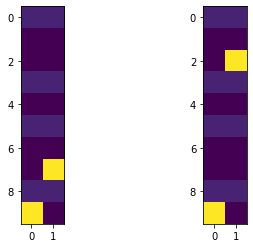

dice_number: 2  player_turn_next:  0


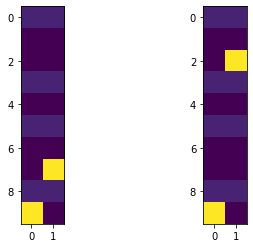

dice_number: 1  player_turn_next:  1


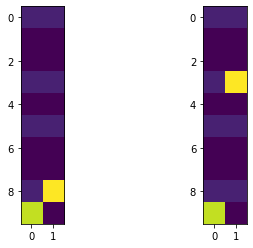

dice_number: 3  player_turn_next:  0


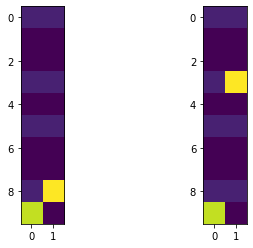

dice_number: 2  player_turn_next:  0


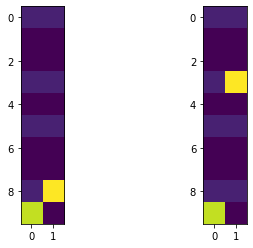

dice_number: 3  player_turn_next:  1


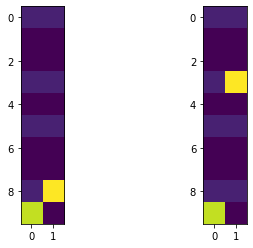

dice_number: 3  player_turn_next:  1


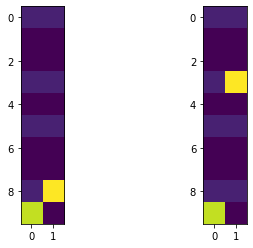

dice_number: 3  player_turn_next:  1


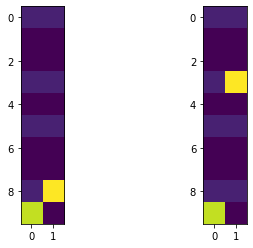

dice_number: 1  player_turn_next:  1


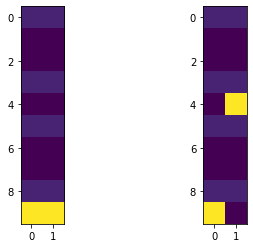

dice_number: 1  player_turn_next:  0


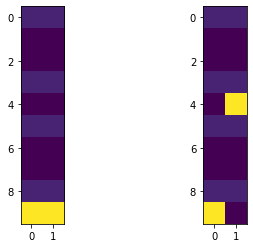

dice_number: 3  player_turn_next:  0


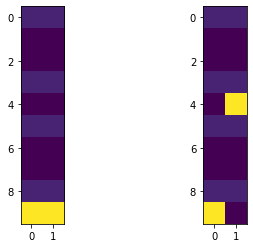

dice_number: 2  player_turn_next:  0


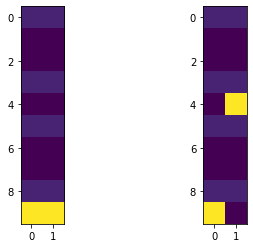

dice_number: 2  player_turn_next:  1


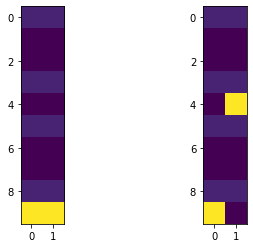

dice_number: 1  player_turn_next:  0


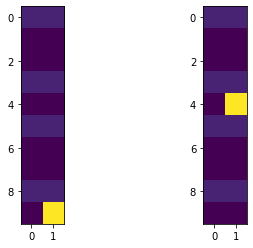

dice_number: 2  player_turn_next:  0
dice_number: 1  player_turn_next:  0


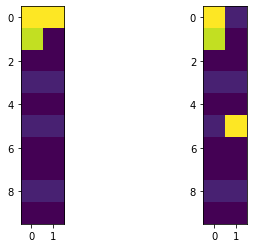

dice_number: 1  player_turn_next:  1


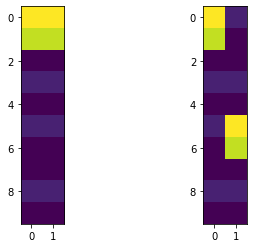

dice_number: 3  player_turn_next:  0


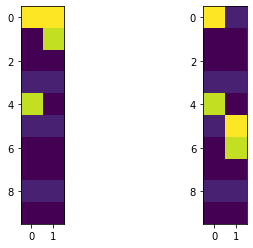

dice_number: 1  player_turn_next:  0


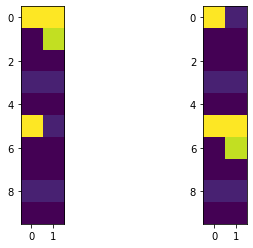

dice_number: 3  player_turn_next:  1


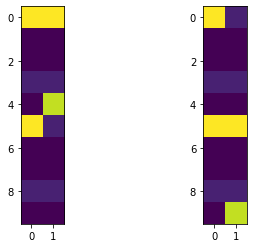

dice_number: 2  player_turn_next:  1


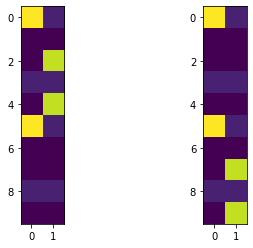

dice_number: 2  player_turn_next:  0
BOOM


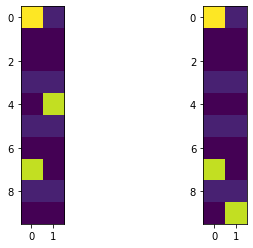

dice_number: 2  player_turn_next:  0


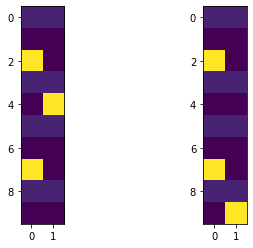

dice_number: 3  player_turn_next:  1


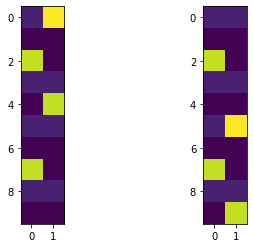

dice_number: 2  player_turn_next:  1
BOOM


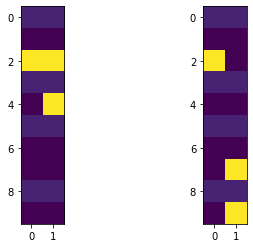

dice_number: 2  player_turn_next:  1


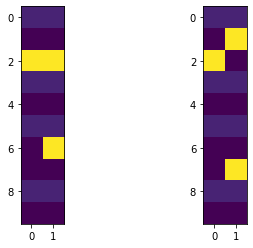

dice_number: 1  player_turn_next:  0


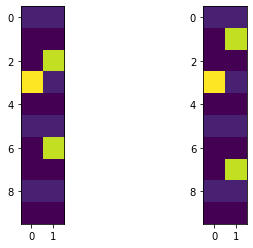

dice_number: 2  player_turn_next:  1


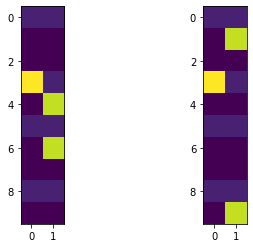

dice_number: 1  player_turn_next:  0


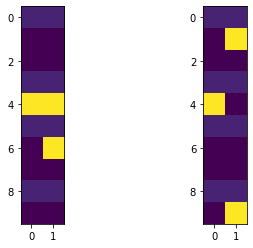

dice_number: 3  player_turn_next:  1


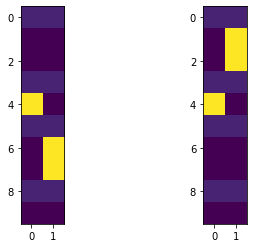

dice_number: 2  player_turn_next:  1
BOOM


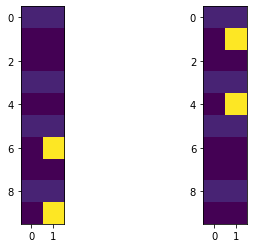

dice_number: 2  player_turn_next:  1


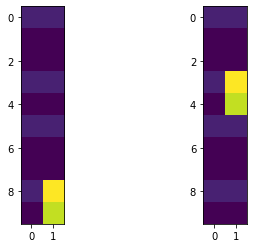

dice_number: 2  player_turn_next:  0


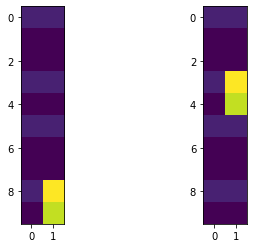

dice_number: 2  player_turn_next:  1


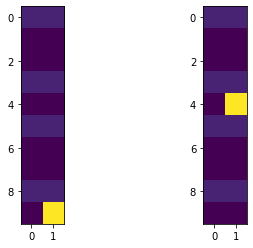

dice_number: 3  player_turn_next:  1


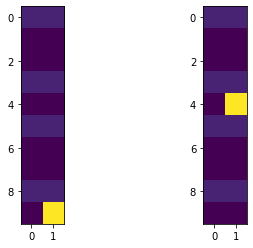

dice_number: 3  player_turn_next:  1


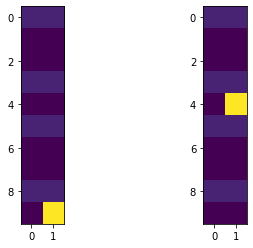

dice_number: 3  player_turn_next:  1


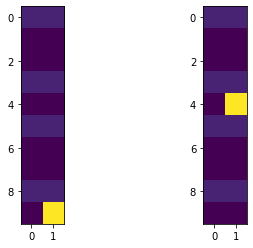

dice_number: 2  player_turn_next:  1


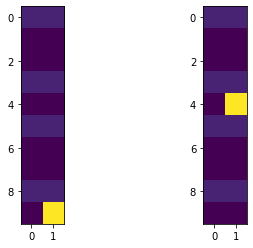

dice_number: 3  player_turn_next:  0


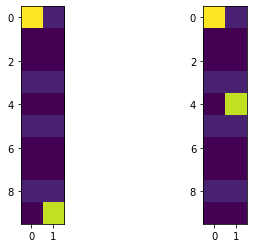

dice_number: 1  player_turn_next:  0


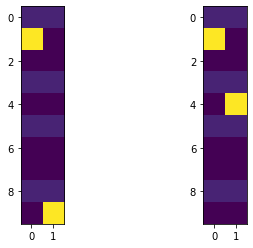

dice_number: 3  player_turn_next:  1


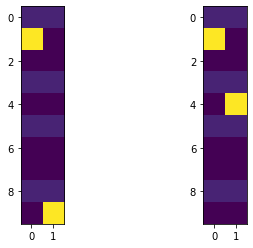

dice_number: 3  player_turn_next:  1


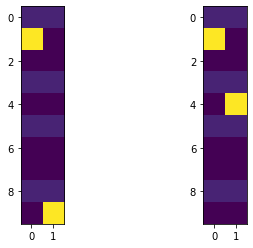

dice_number: 3  player_turn_next:  1


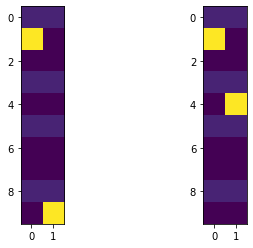

dice_number: 2  player_turn_next:  1


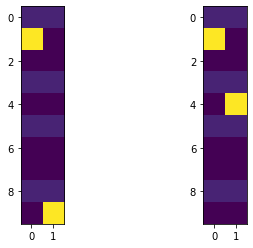

dice_number: 1  player_turn_next:  0


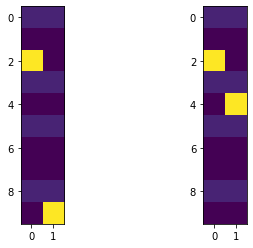

dice_number: 3  player_turn_next:  1


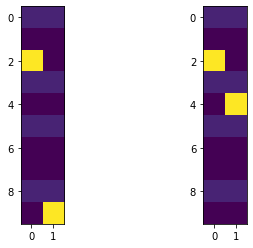

dice_number: 2  player_turn_next:  1


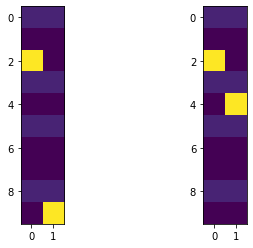

dice_number: 1  player_turn_next:  0


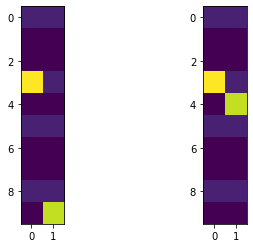

dice_number: 2  player_turn_next:  1


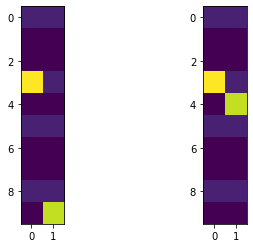

dice_number: 3  player_turn_next:  0


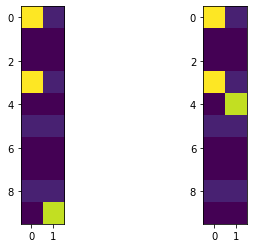

dice_number: 2  player_turn_next:  0


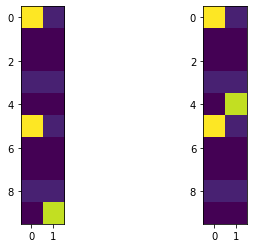

dice_number: 3  player_turn_next:  1


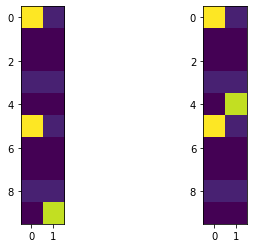

dice_number: 2  player_turn_next:  1


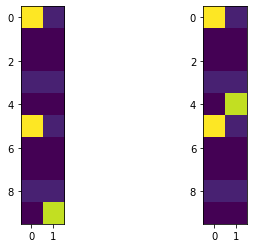

dice_number: 1  player_turn_next:  0


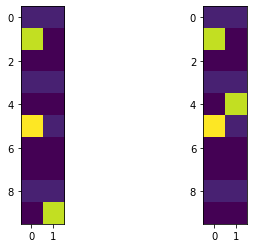

dice_number: 1  player_turn_next:  1


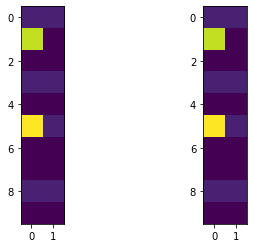

dice_number: 2  player_turn_next:  1
dice_number: 2  player_turn_next:  0


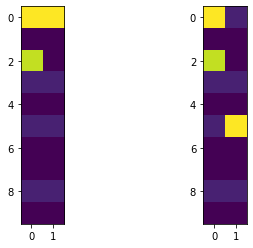

dice_number: 3  player_turn_next:  1


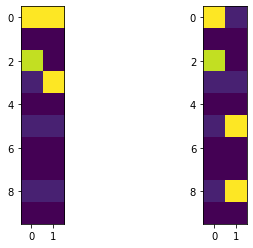

dice_number: 3  player_turn_next:  1


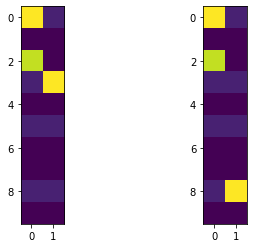

dice_number: 2  player_turn_next:  1


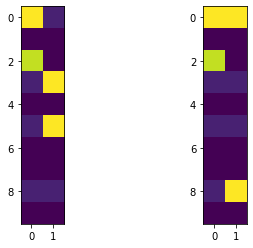

dice_number: 1  player_turn_next:  0


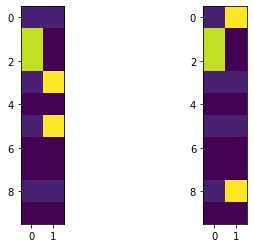

dice_number: 1  player_turn_next:  1


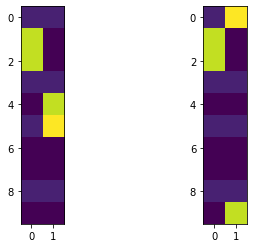

dice_number: 2  player_turn_next:  0


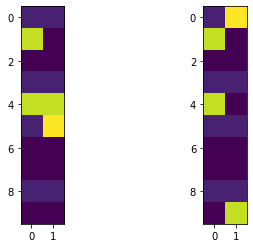

dice_number: 2  player_turn_next:  1
BOOM


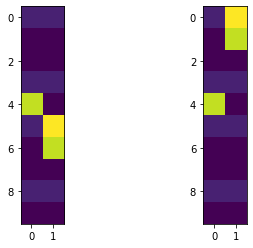

dice_number: 3  player_turn_next:  1


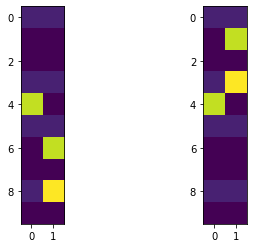

dice_number: 2  player_turn_next:  1


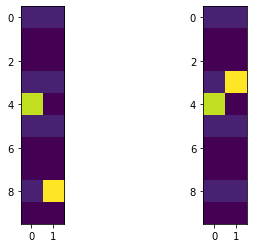

dice_number: 2  player_turn_next:  0


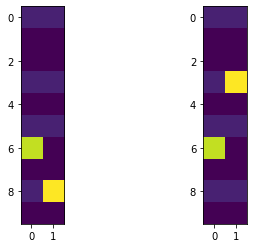

dice_number: 1  player_turn_next:  1


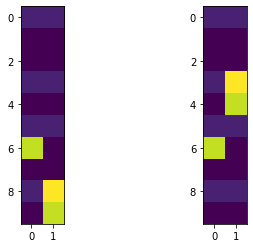

dice_number: 3  player_turn_next:  0


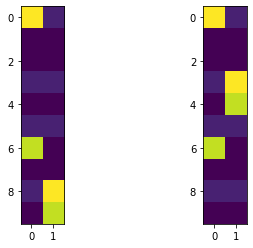

dice_number: 2  player_turn_next:  0


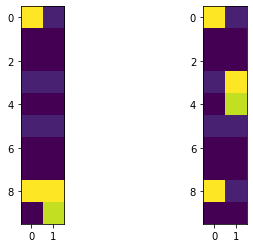

dice_number: 1  player_turn_next:  1


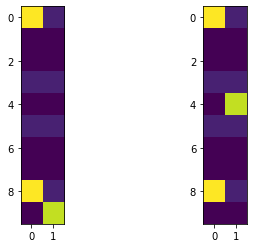

dice_number: 2  player_turn_next:  0


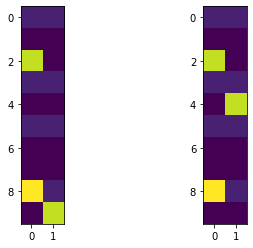

dice_number: 1  player_turn_next:  1


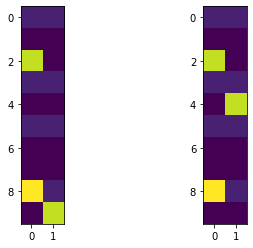

dice_number: 1  player_turn_next:  1


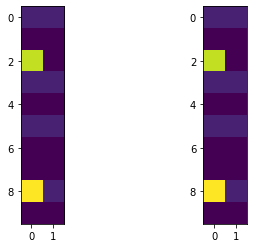

dice_number: 2  player_turn_next:  1


In [ ]:
import time
env.verbose = True
for episode in range(10):
    observation = env.reset()
    
    positions_all, dice_face, player_turn, moves_left = observation
    print('dice_number:', dice_face, ' player_turn_next: ',player_turn)
    
    positions_adjusted = positions_all[player_turn*env.NUM_PIECES:] + positions_all[:player_turn*env.NUM_PIECES]
    
    done = False
    reward_this_ep = 0
    
    state = tuple(positions_adjusted + [dice_face -1])
    while not done:
        
        action = np.argmax(q_table[state])
        
        next_obs, reward, done, _ = env.step(action)
        env.render()
        
        p_all_next, dice_face_next, player_turn_next, moves_left_next = next_obs
        positions_adjusted_next = p_all_next[player_turn_next*env.NUM_PIECES:] + p_all_next[:player_turn_next*env.NUM_PIECES]
        print('dice_number:', dice_face_next, ' player_turn_next: ',player_turn_next)
        
        next_state = tuple(positions_adjusted_next + [dice_face_next-1])
                    
        positions_all, dice_face, player_turn, moves_left = p_all_next, dice_face_next, player_turn_next, moves_left_next
        state = next_state


-14.530729472852588